In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np

from sed_scores_eval import intersection_based

import glob
import os
import time

import datasets
import evaluate
import matplotlib.pyplot as plt

import sound_event_eval as see
import config



In [4]:
#ls './results/test-2024-01-31/baby/n_queries_30_noise_0.0_prominence_threshold_0.0_coverage_threshold_0.05/ADP/0/test_scores/prototypical/budget_1.0/'
#os.chdir('~/gits/active-learning-for-bioacoustics')
print(os.getcwd())

/home/john/gits/active-learning-for-bioacoustics/notebooks


In [5]:
os.chdir('/home/john/gits/active-learning-for-bioacoustics/')

result_dir =  '/mnt/storage_1/john/al_for_sed_results/2024-01-31/'

# find all config.yaml files in the result_dir
config_files = glob.glob(os.path.join(result_dir, '**', 'config.yaml'), recursive=True)
print(len(config_files))

#for config_file in config_files:

conf = config.Config()
conf.load_config_yaml(config_files[0])
#print(config_file)
#see.evaluate_test_and_train(conf)
os.chdir('/home/john/gits/active-learning-for-bioacoustics/notebooks')

1320


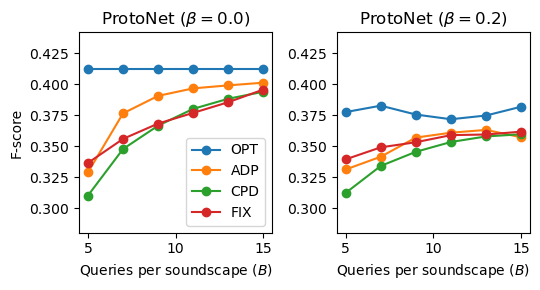

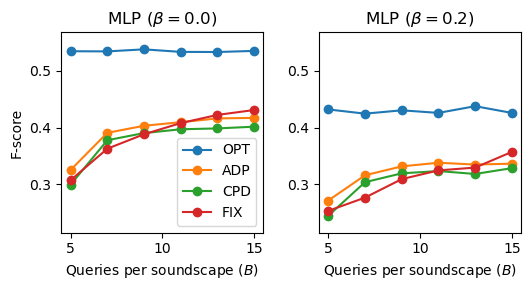

In [17]:
os.chdir('/home/john/gits/active-learning-for-bioacoustics/')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
noise_styles = ['-', '--']

split = 'Test'
figsize = (3.5, 6)
figsize_side_by_side = (5.5, 3)
n_columns = 2
n_rows    = 1

model_names = ['ProtoNet', 'MLP']
metric_names = ['F-score', 'Precision', 'Recall']

for idx_model, model_name in enumerate(['prototypical', 'mlp']):
    event_based_df, segment_based_df = conf.load_test_results(model_name=model_name)
    prominence_threshold = 0.0
    coverage_threshold   = 0.5

    df = segment_based_df[segment_based_df['model_name'] == model_name]
    df = df[df['prominence_threshold'] == prominence_threshold]
    df = df[df['coverage_threshold'] == coverage_threshold]

    fig, ax = plt.subplots(n_rows, n_columns, figsize=figsize_side_by_side)

    for idx_metric, metric_name in enumerate(['f_measure']):
        values = []
        for idx_noise, noise in enumerate([0.0, 0.2]):
            for idx_strat, strategy_name in enumerate(['OPT', 'ADP', 'CPD', 'FIX']):
                
                _df = df[df['strategy_name'] == strategy_name]
                _df = _df[_df['fn_noise'] == noise]
                _df = _df[_df['fp_noise'] == noise]
                average_df = _df.groupby(['n_queries'])[metric_name].mean().reset_index()

                #print(len(average_df))

                # plot n_queries vs. f1-score
                title = r'{} ($\beta = {}$)'.format(model_names[idx_model], noise)

                ax[idx_noise].set_title(title)

                ax[idx_noise].set_xlabel(r'Queries per soundscape ($B$)')

                if idx_noise == 0:
                    ax[idx_noise].set_ylabel(metric_names[idx_metric])
                # plot the average f_measure for each n_queries over class_name

                # skip legend if noise is 0.2
                #if noise == 0.0:
                ax[idx_noise].plot(average_df['n_queries'][:6], average_df[metric_name][:6], '-o', color=colors[idx_strat], label='{}'.format(strategy_name))

                values.append(average_df[metric_name].values[:6])

                # plot a shaded area around x = 0 to x = 13
                #ax[idx_noise, idx_model].fill_between([5, 13], 0.2, 0.55, alpha=0.2, color='grey')

                #else:
                #    ax[idx_model].plot(average_df['n_queries'], average_df[metric_name], noise_styles[idx_noise], color=colors[idx_strat])
                #plt.fill_between(average_df.index, average_df.values - std_df.values, average_df.values + std_df.values, alpha=0.2)

        values = np.concatenate(values)
        min_value = np.min(values) - 0.03
        max_value = np.max(values) + 0.03
        ax[0].set_ylim(min_value, max_value)
        ax[1].set_ylim(min_value, max_value)

        #plt.ylim(0.1, 0.6)
    plt.tight_layout()
    ax[0].legend()
    #plt.legend() #bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('figures/{}_test.pdf'.format(model_name), format='pdf', dpi=1200)
                #plt.show()

#segment_based_df

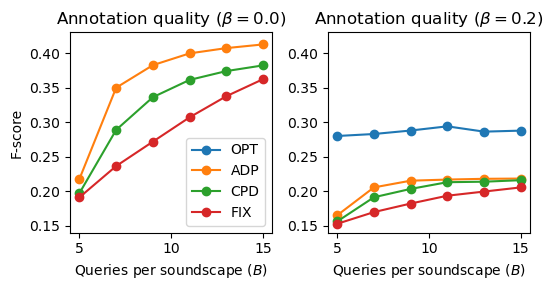

In [18]:
os.chdir('/home/john/gits/active-learning-for-bioacoustics/')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
noise_styles = ['-', '--']

split = 'Train'
metric_names = ['F-score', 'Precision', 'Recall']

event_based_df, segment_based_df = conf.load_train_results(model_name=model_name)
prominence_threshold = 0.0
coverage_threshold   = 0.5

df = segment_based_df[segment_based_df['model_name'] == model_name]
df = df[df['prominence_threshold'] == prominence_threshold]
df = df[df['coverage_threshold'] == coverage_threshold]

#plt.figure(figsize=(4, 3.5))
fig, ax = plt.subplots(n_rows, n_columns, figsize=figsize_side_by_side)
for idx_metric, metric_name in enumerate(['f_measure']):
    for idx_noise, noise in enumerate([0.0, 0.2]):
        for idx_strat, strategy_name in enumerate(['OPT', 'ADP', 'CPD', 'FIX']):
            
            _df = df[df['strategy_name'] == strategy_name]
            _df = _df[_df['fn_noise'] == noise]
            _df = _df[_df['fp_noise'] == noise]
            average_df = _df.groupby(['n_queries'])[metric_name].mean().reset_index()

            # plot n_queries vs. f1-score
            title = r'Annotation quality ($\beta = {}$)'.format(noise) #'Dataset = {}'.format(split)

            ax[idx_noise].set_title(title)
            #if idx_noise == 1:
            ax[idx_noise].set_xlabel(r'Queries per soundscape ($B$)')

            if idx_noise == 0:
                ax[idx_noise].set_ylabel(metric_names[idx_metric])
            # plot the average f_measure for each n_queries over class_name

            #if strategy_name == 'OPT' and noise == 0.0:
            #    continue

            #if noise == 0.2:
            ax[idx_noise].plot(average_df['n_queries'][:6], average_df[metric_name][:6], '-o', color=colors[idx_strat], label='{}'.format(strategy_name))
            ax[idx_noise].set_ylim(0.14, 0.43)
            #ax[idx_noise].fill_between([5, 13], 0.1, 0.5, alpha=0.2, color='grey')
            #else:
            #    plt.plot(average_df['n_queries'], average_df[metric_name], noise_styles[idx_noise], color=colors[idx_strat])
            #plt.fill_between(average_df.index, average_df.values - std_df.values, average_df.values + std_df.values, alpha=0.2)

            #plt.ylim(0.1, 0.6)
plt.tight_layout()
ax[0].legend() #bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('figures/train.pdf', format='pdf', dpi=1200)
            #plt.show()

#segment_based_df

In [13]:
os.chdir('/home/john/gits/active-learning-for-bioacoustics/')

result_dir =  '/mnt/storage_1/john/al_for_sed_results/2024-02-08/'

# find all config.yaml files in the result_dir
config_files = glob.glob(os.path.join(result_dir, '**', 'config.yaml'), recursive=True)
print(len(config_files))

conf = config.Config()
conf.load_config_yaml(config_files[0])


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
noise_styles = ['-', '--']

#split = 'Train'
metric_names = ['F-score', 'Precision', 'Recall']

model_name = 'mlp'
event_based_df, segment_based_df = conf.load_test_results(model_name=model_name)
prominence_threshold = 0.0
coverage_threshold   = 0.5
n_queries = 7

df = segment_based_df[segment_based_df['model_name'] == model_name]
df = df[df['prominence_threshold'] == prominence_threshold]
df = df[df['coverage_threshold'] == coverage_threshold]
df = df[df['n_queries'] == n_queries]

df_event = event_based_df[event_based_df['model_name'] == model_name]
df_event = df_event[df_event['prominence_threshold'] == prominence_threshold]
df_event = df_event[df_event['coverage_threshold'] == coverage_threshold]
df_event = df_event[df_event['n_queries'] == n_queries]

for idx_metric, metric_name in enumerate(['f_measure']):
    for idx_noise, noise in enumerate([0.0, 0.2]):
        print("Strategy & Meerkat & Dog & Baby \\\\")
        print("\hline")
        for idx_strat, strategy_name in enumerate(['OPT', 'ADP', 'CPD', 'FIX']):
            row_str = strategy_name
            for class_name in ['me', 'dog', 'baby']:

                #print("--------------------------------------------------------------")
                #print("{}, {}".format(metric_name, noise))
                #print("--------------------------------------------------------------")

                #caption = 'The mean and std {} annotation quality for each strategy with the sufficient and necessary budget N=7. The results are for class {} and noise level {}.'.format(metric_name, class_name, noise)

                # print code for latex table with 3 columns

    
                _df = df[df['strategy_name'] == strategy_name]
                _df = _df[_df['fn_noise'] == noise]
                _df = _df[_df['fp_noise'] == noise]
                _df = _df[_df['class_name'] == class_name]
                average_df = _df.groupby(['n_queries'])[metric_name].mean().reset_index()
                std_df = _df.groupby(['n_queries'])[metric_name].std().reset_index()

                n_runs = 15
                n_classes = 3
                assert(len(_df) == n_runs)

                # _df_event = df_event[df_event['strategy_name'] == strategy_name]
                # _df_event = _df_event[_df_event['fn_noise'] == noise]
                # _df_event = _df_event[_df_event['fp_noise'] == noise]
                # _df_event = _df_event[_df_event['class_name'] == class_name]

                # assert(len(_df) == n_runs)

                # average_df_event = _df_event.groupby(['n_queries'])[metric_name].mean().reset_index()
                # std_df_event = _df_event.groupby(['n_queries'])[metric_name].std().reset_index()

                #row_str += " & ${:.2f}$ & ${:.2f}$".format(average_df[metric_name].values[0], average_df_event[metric_name].values[0])
                row_str += " & ${:.2f} \\pm {:.2f}$".format(average_df[metric_name].values[0], std_df[metric_name].values[0])
                #print("{} & {:.2f} \\pm {:.2f} & {:.2f} \\pm {:.2f} \\\\".format(strategy_name, average_df[metric_name].values[0], std_df[metric_name].values[0], average_df_event[metric_name].values[0], std_df_event[metric_name].values[0]))
            #print("\\caption {}".format(caption))
            row_str += " \\\\"
            print(row_str)
            if strategy_name == 'OPT':
                print("\\hline")
for _ in range(20):
    print("")

24
Strategy & Meerkat & Dog & Baby \\
\hline
OPT & $0.38 \pm 0.01$ & $0.43 \pm 0.01$ & $0.78 \pm 0.00$ \\
\hline
ADP & $0.23 \pm 0.00$ & $0.29 \pm 0.01$ & $0.65 \pm 0.00$ \\
CPD & $0.22 \pm 0.00$ & $0.27 \pm 0.01$ & $0.65 \pm 0.00$ \\
FIX & $0.20 \pm 0.01$ & $0.26 \pm 0.01$ & $0.63 \pm 0.01$ \\
Strategy & Meerkat & Dog & Baby \\
\hline
OPT & $0.30 \pm 0.02$ & $0.32 \pm 0.02$ & $0.67 \pm 0.02$ \\
\hline
ADP & $0.19 \pm 0.01$ & $0.22 \pm 0.01$ & $0.54 \pm 0.02$ \\
CPD & $0.17 \pm 0.01$ & $0.19 \pm 0.02$ & $0.55 \pm 0.03$ \\
FIX & $0.15 \pm 0.01$ & $0.19 \pm 0.01$ & $0.52 \pm 0.03$ \\






















/tmp/ipykernel_1540/1026140871.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))


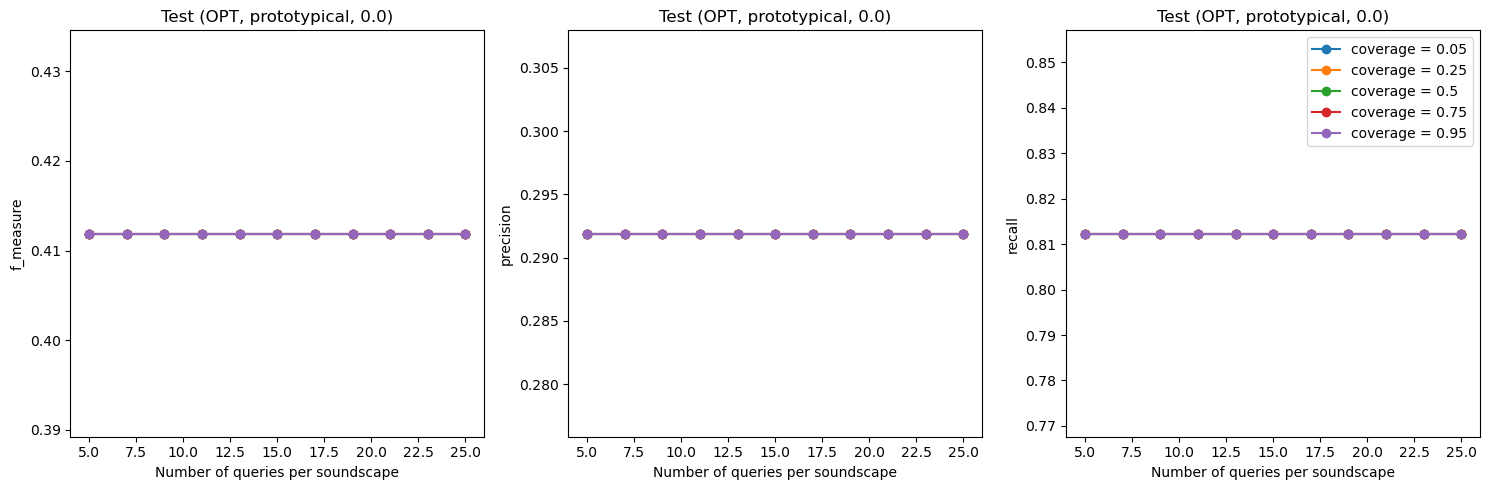

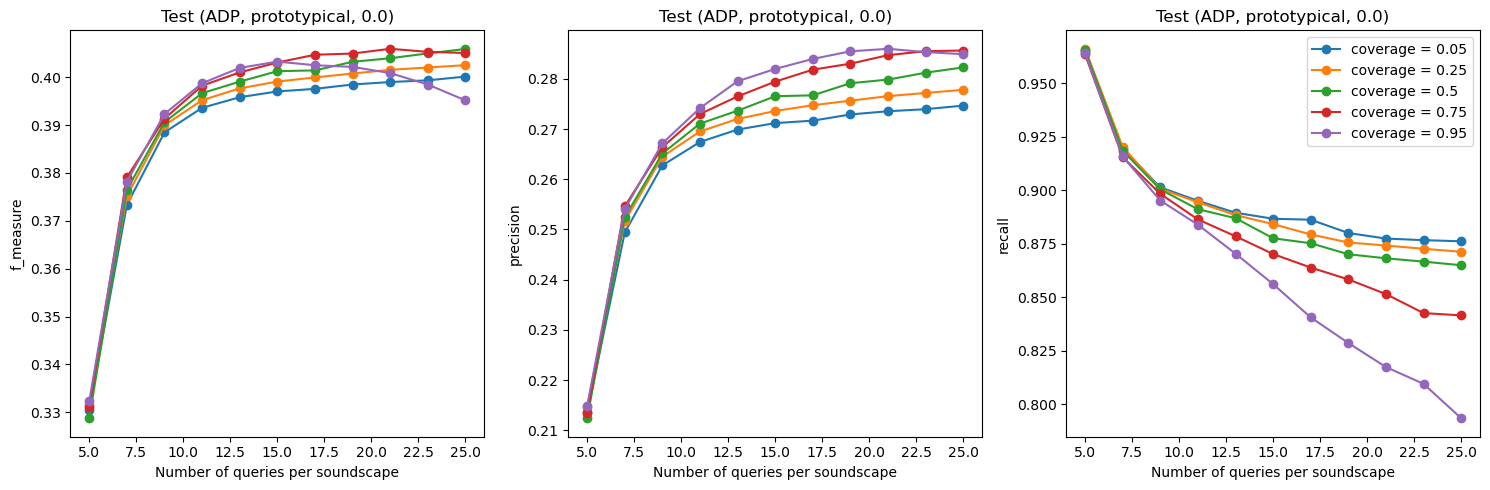

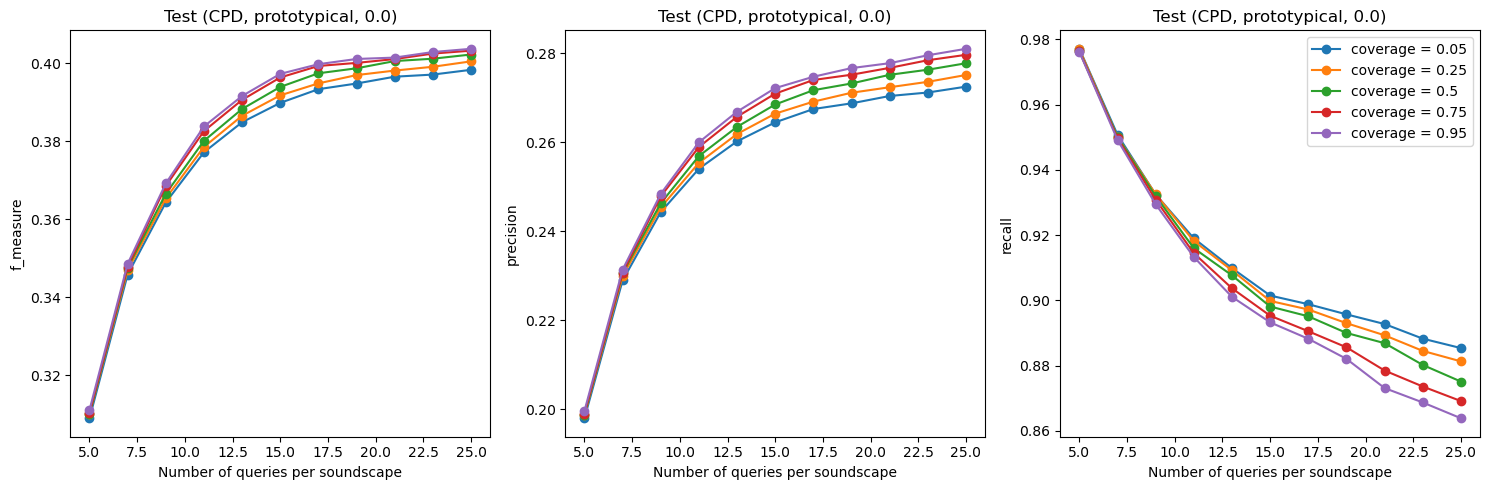

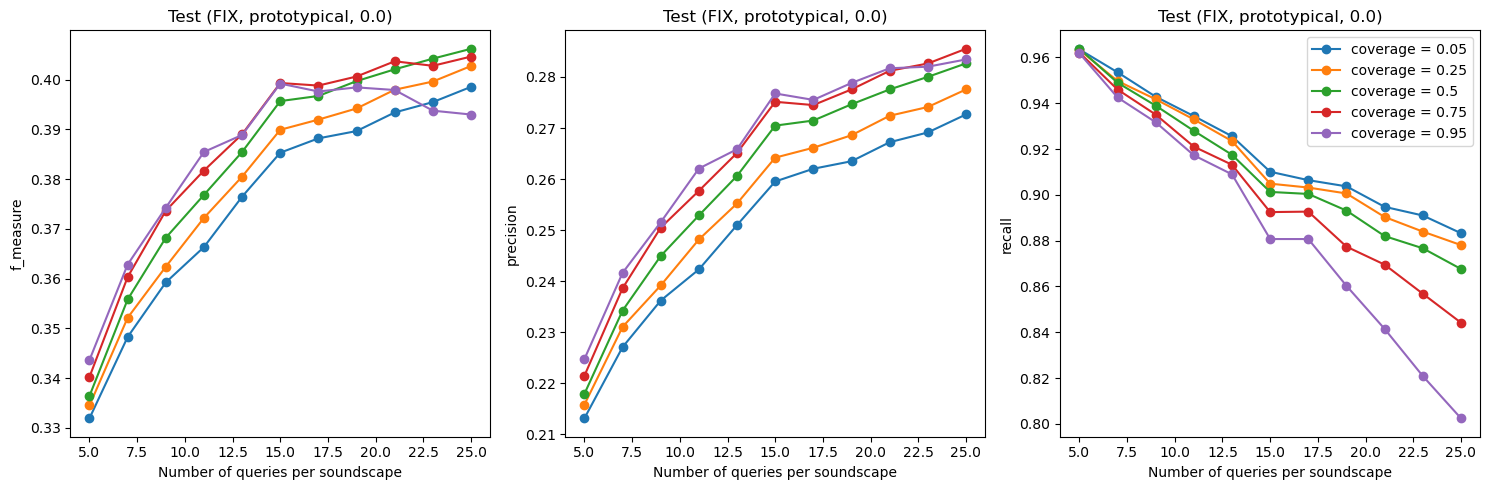

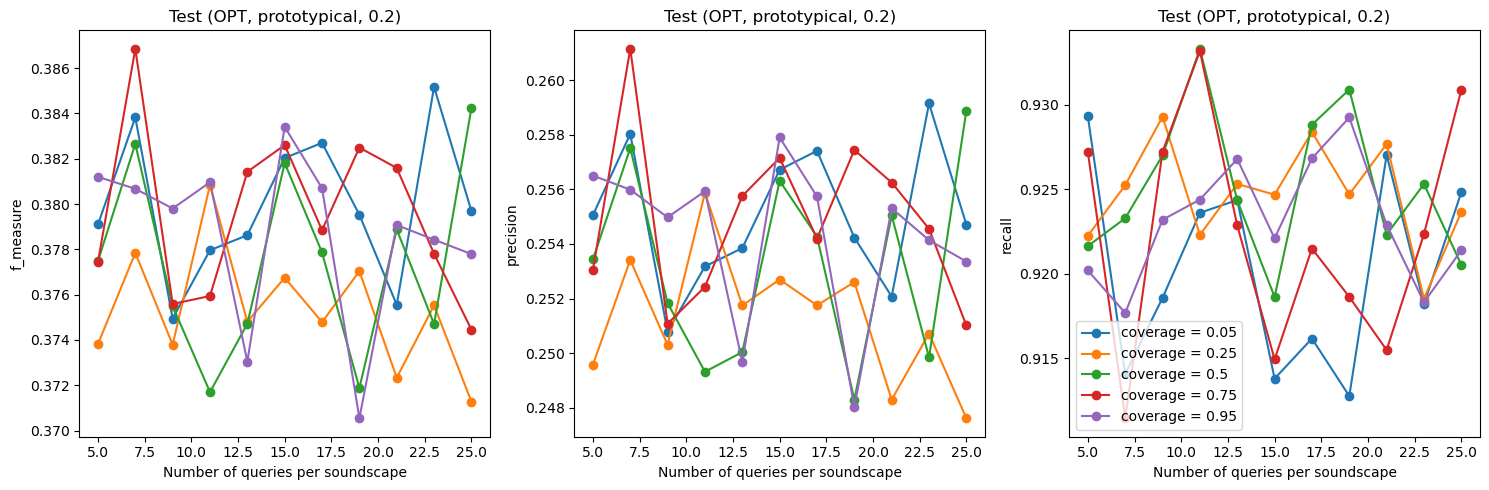

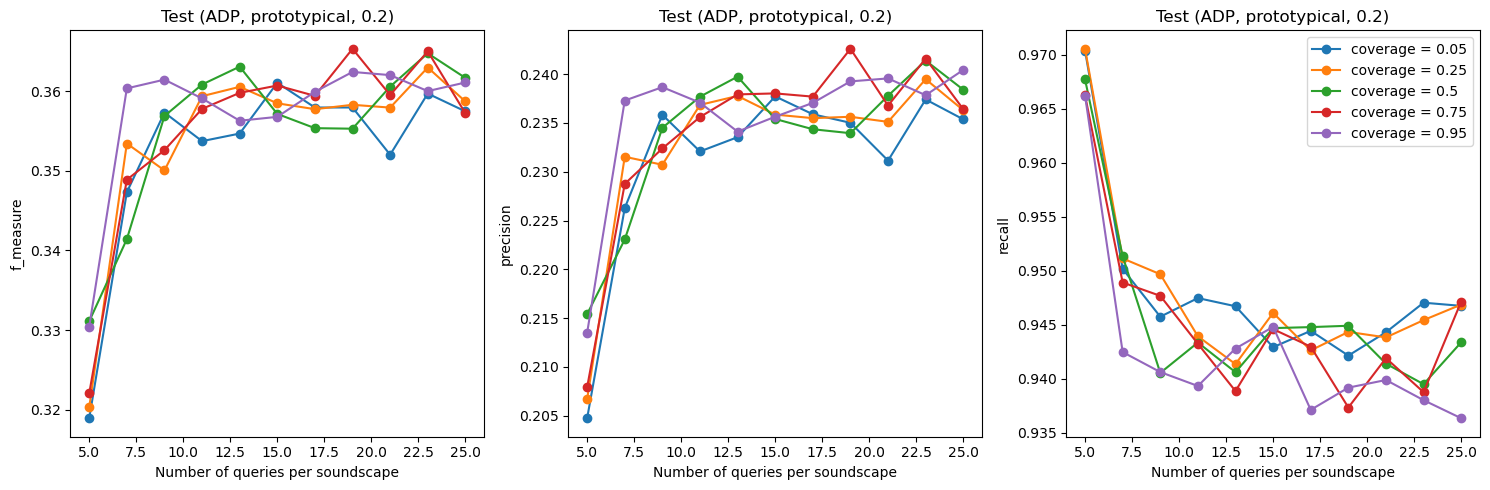

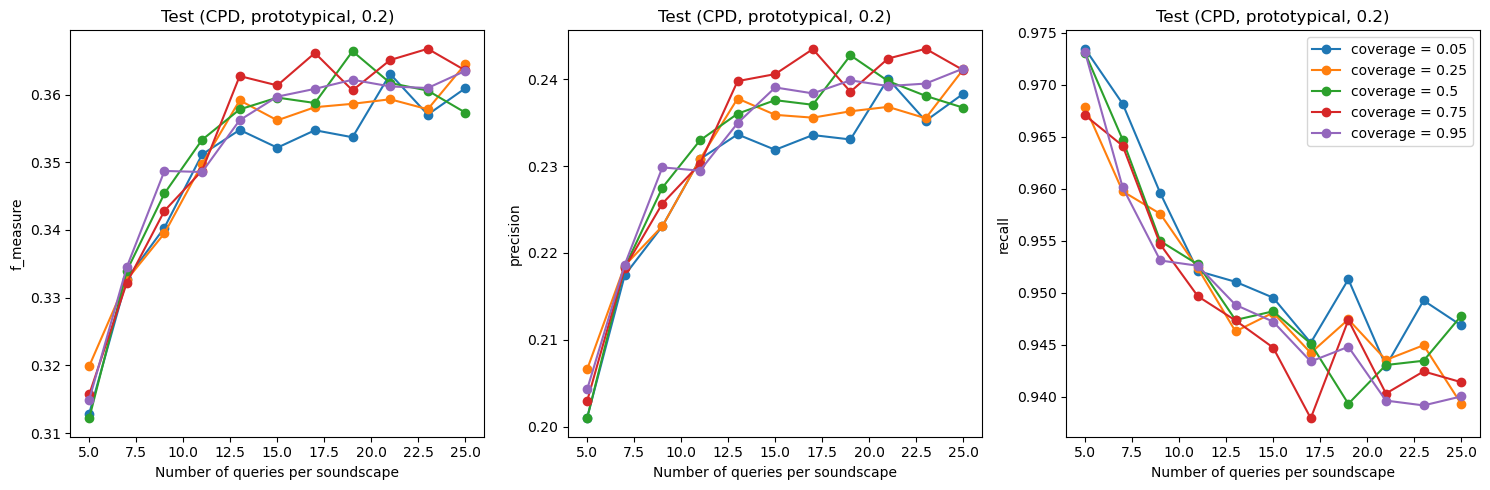

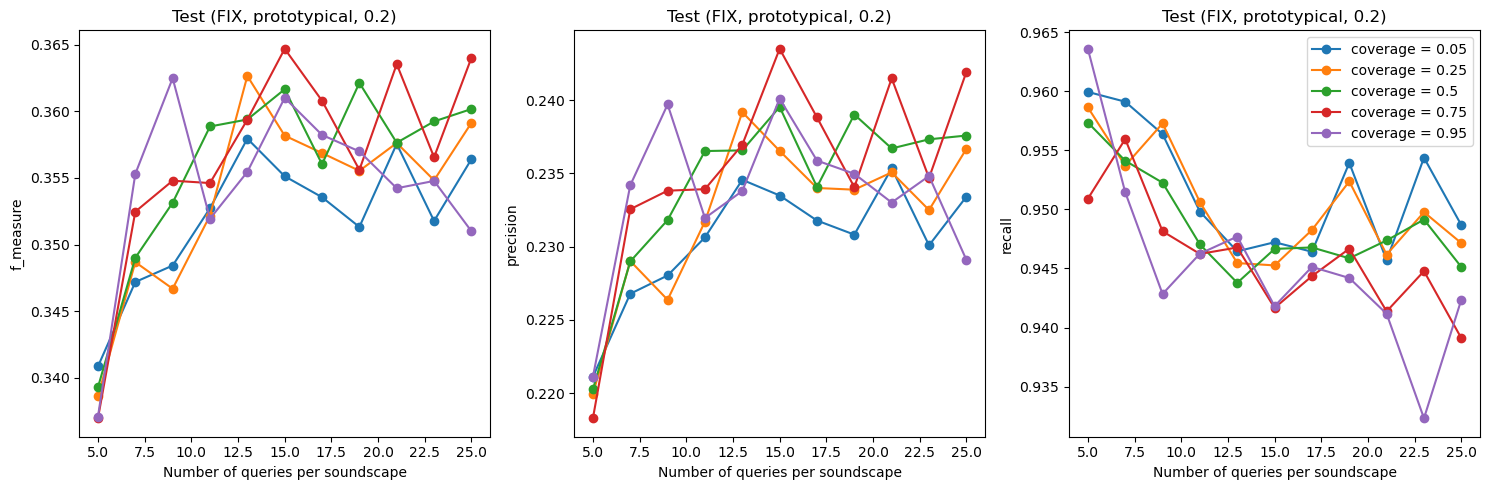

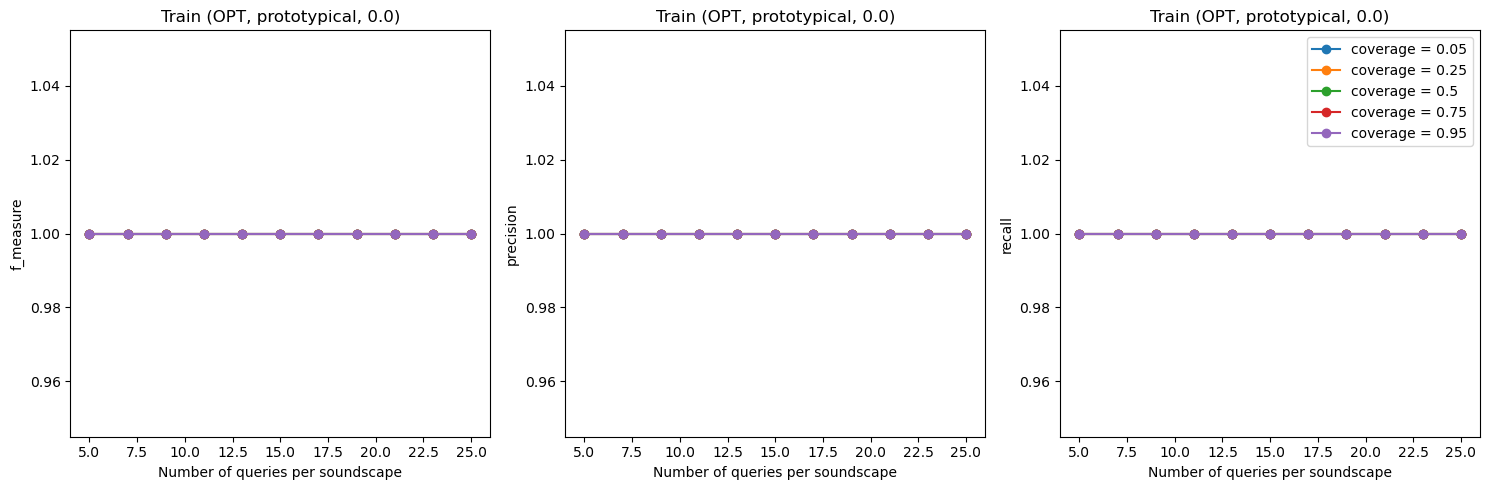

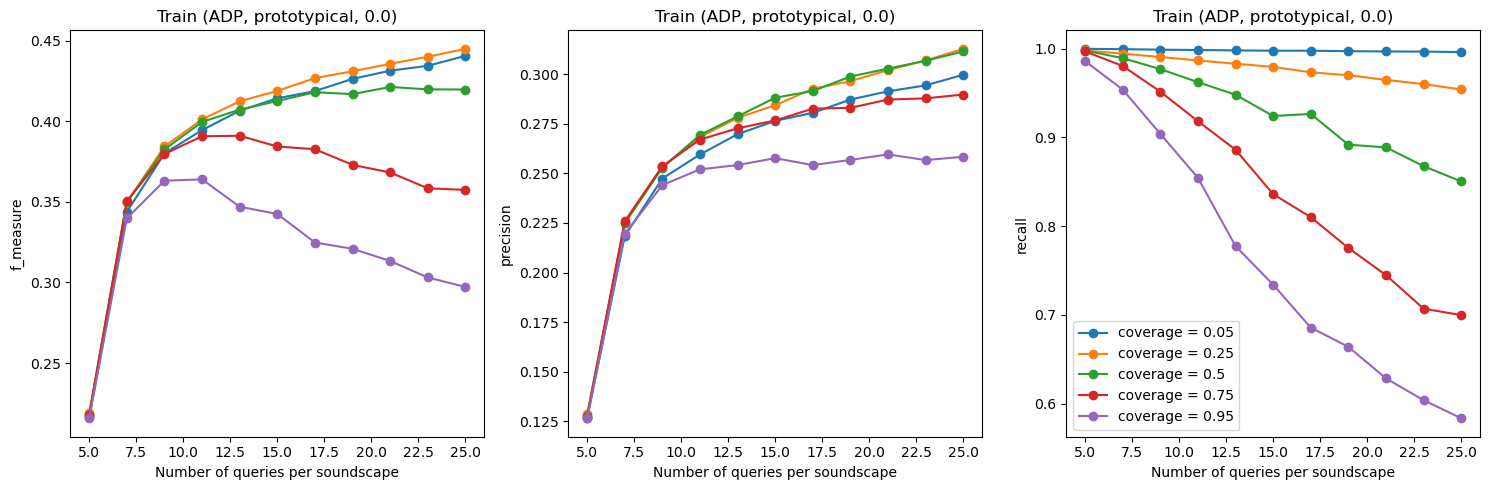

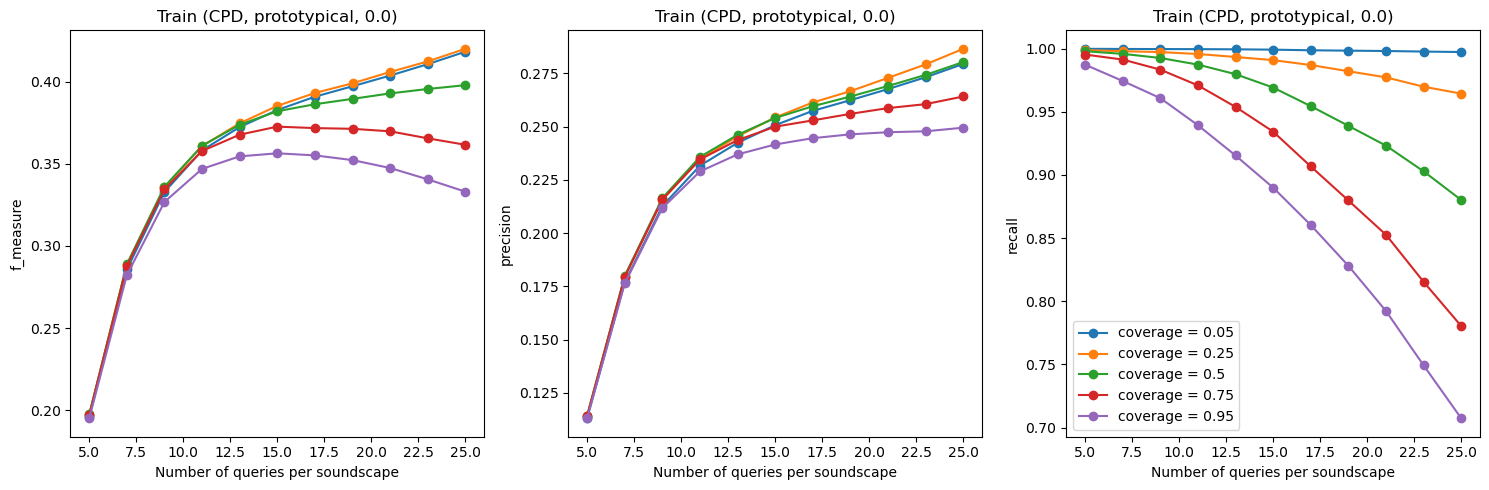

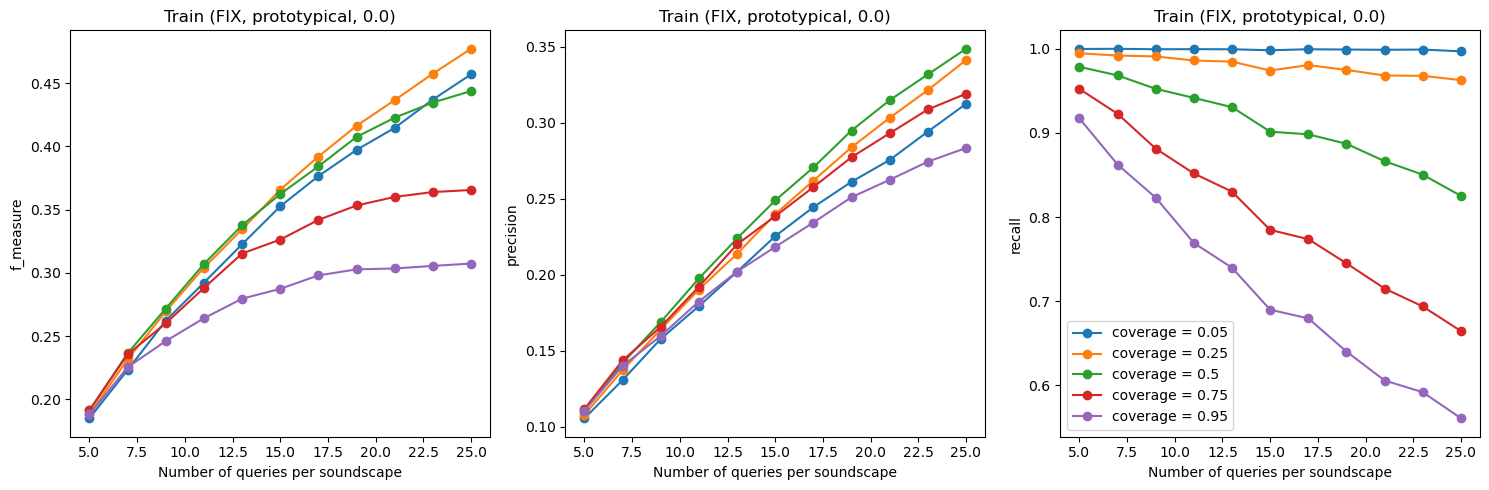

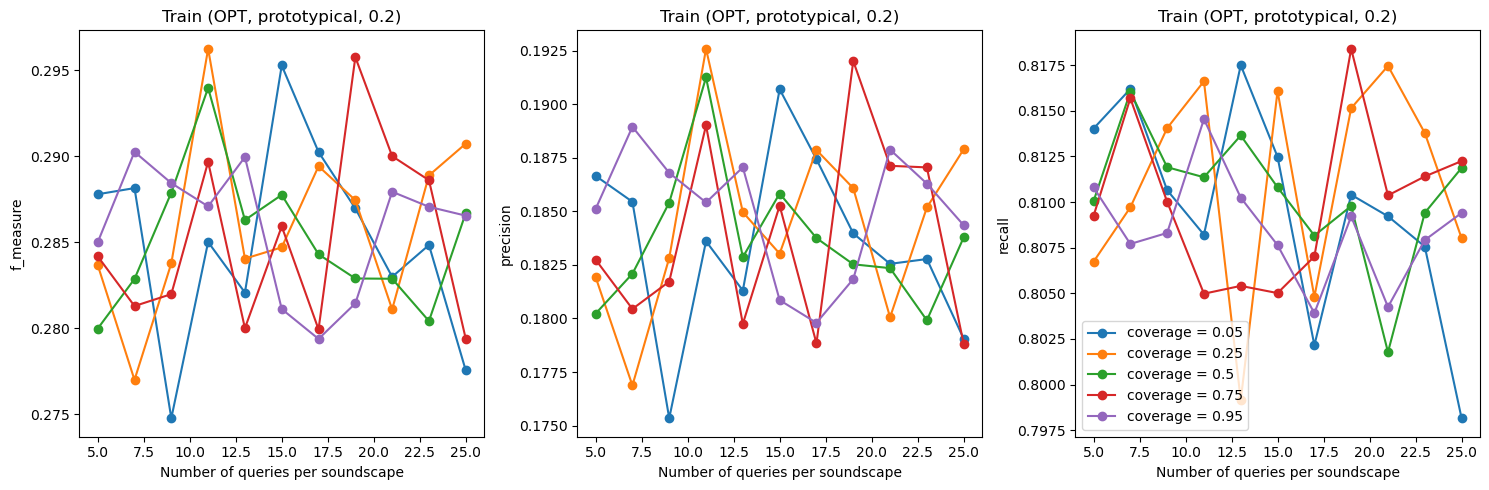

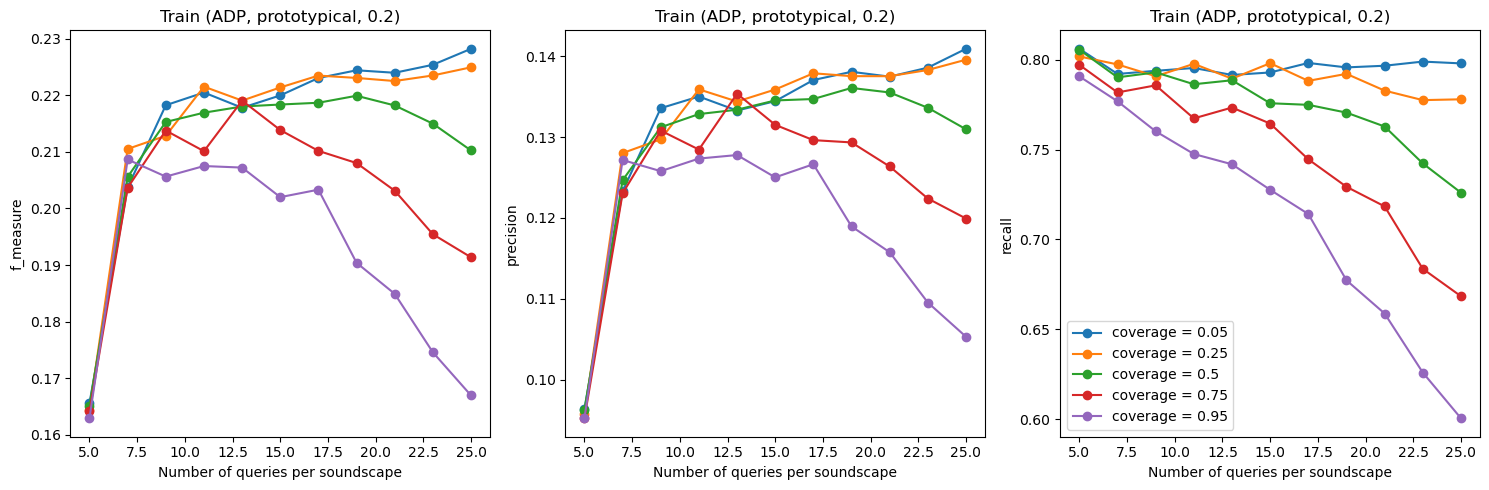

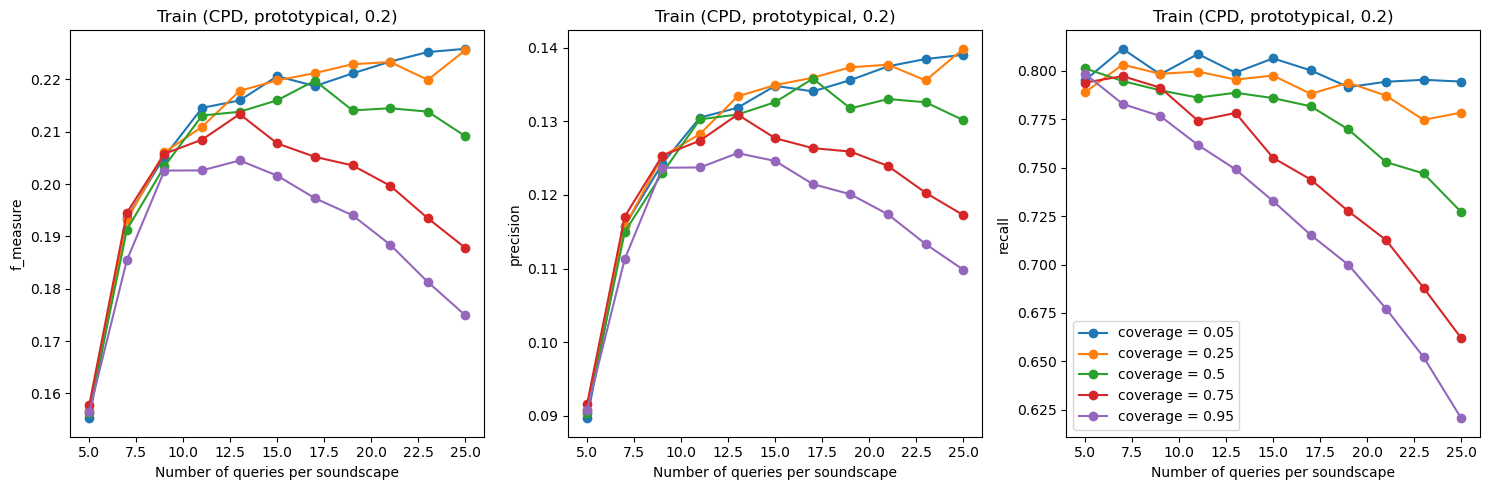

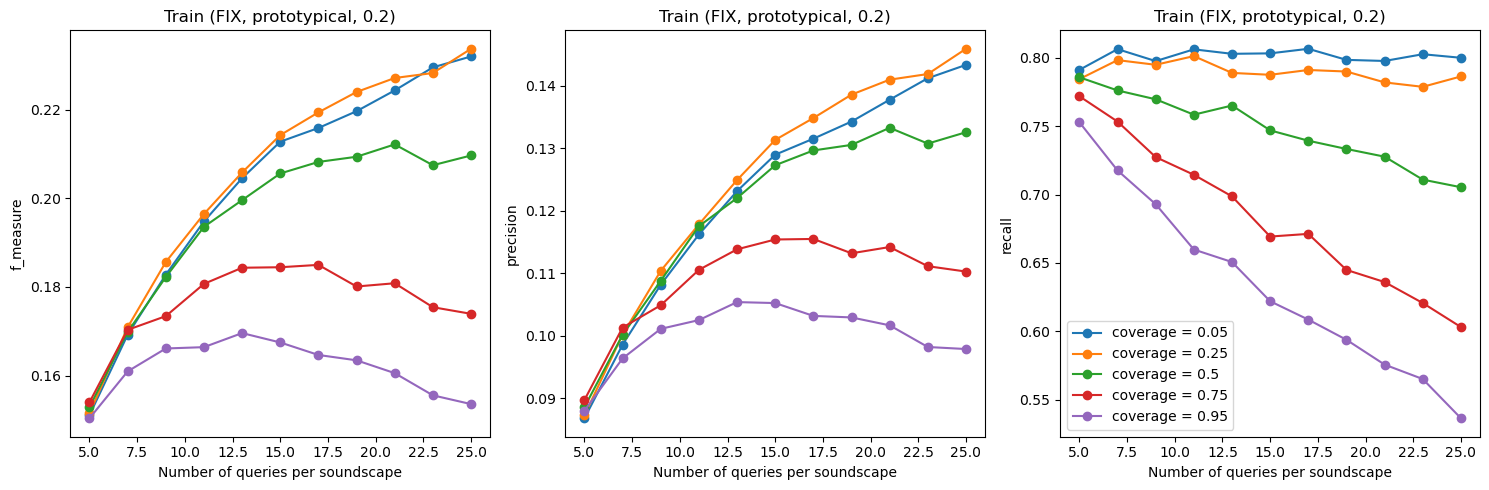

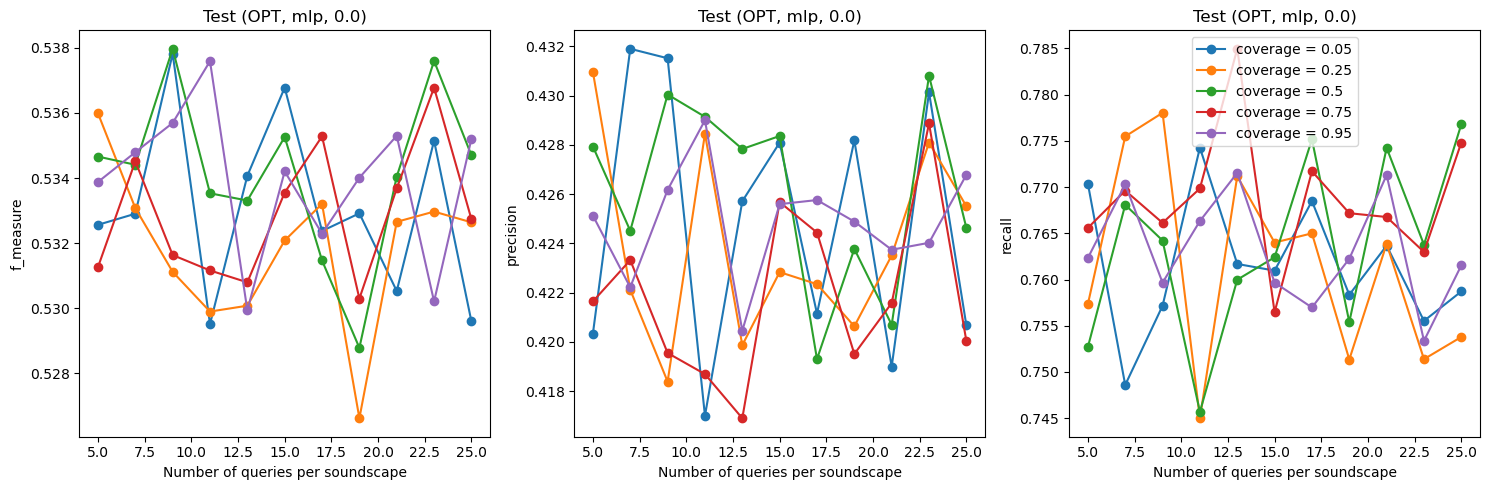

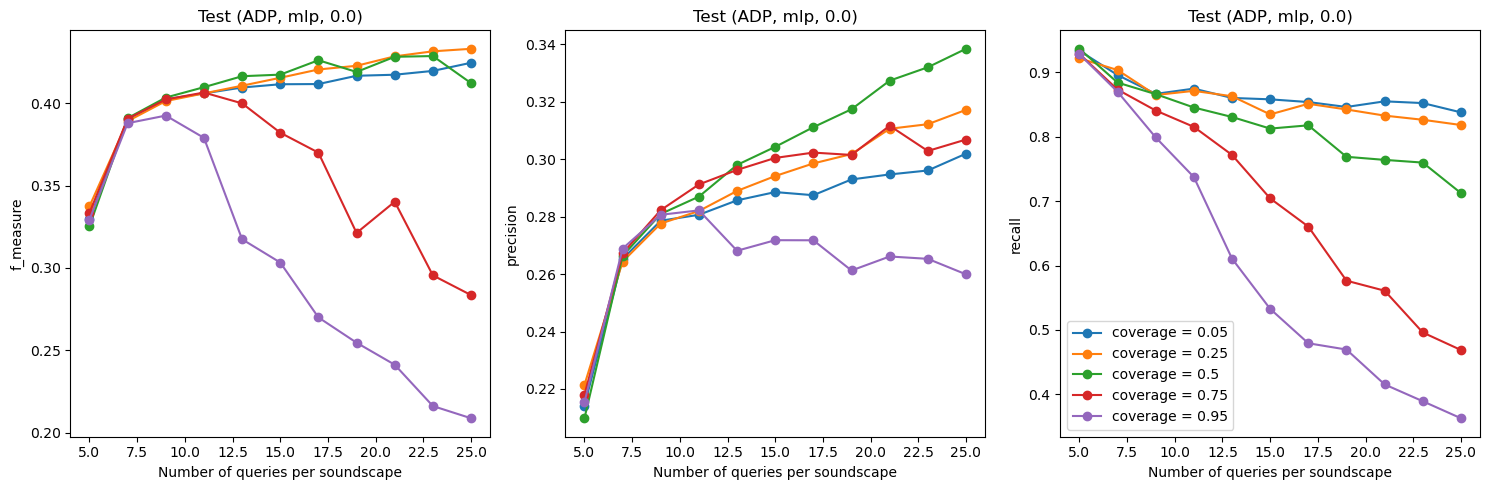

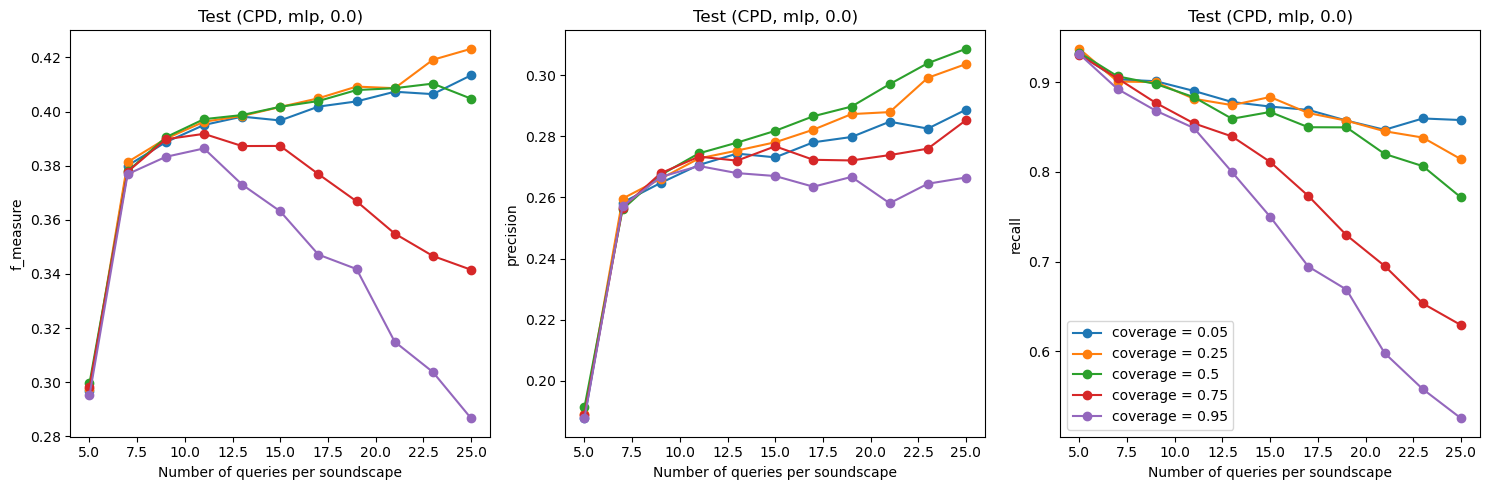

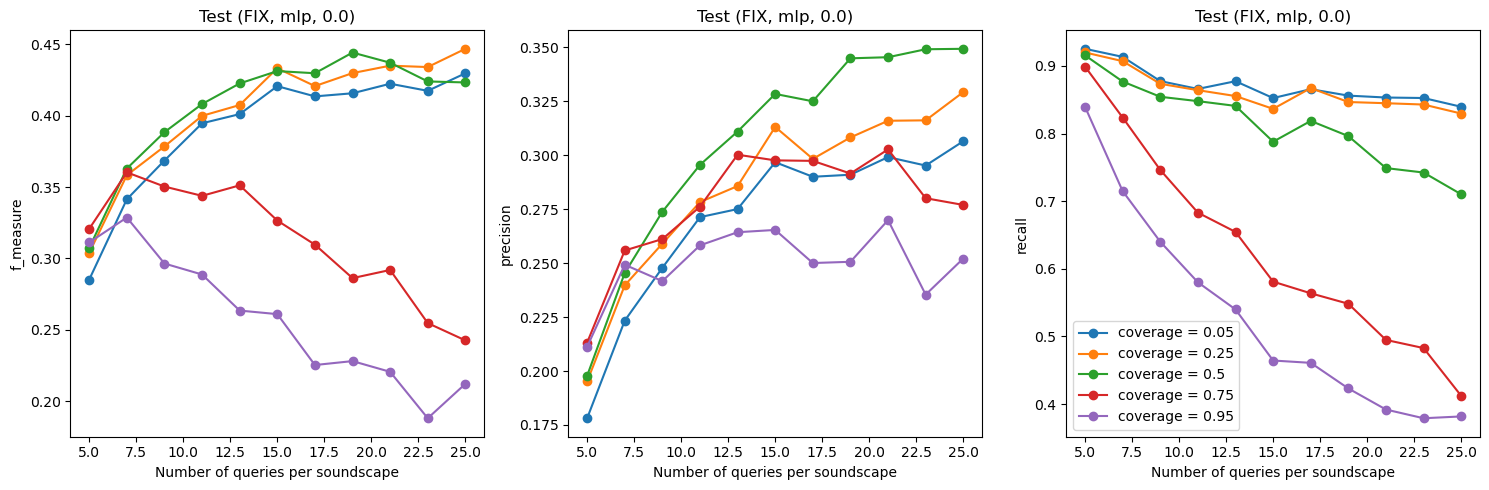

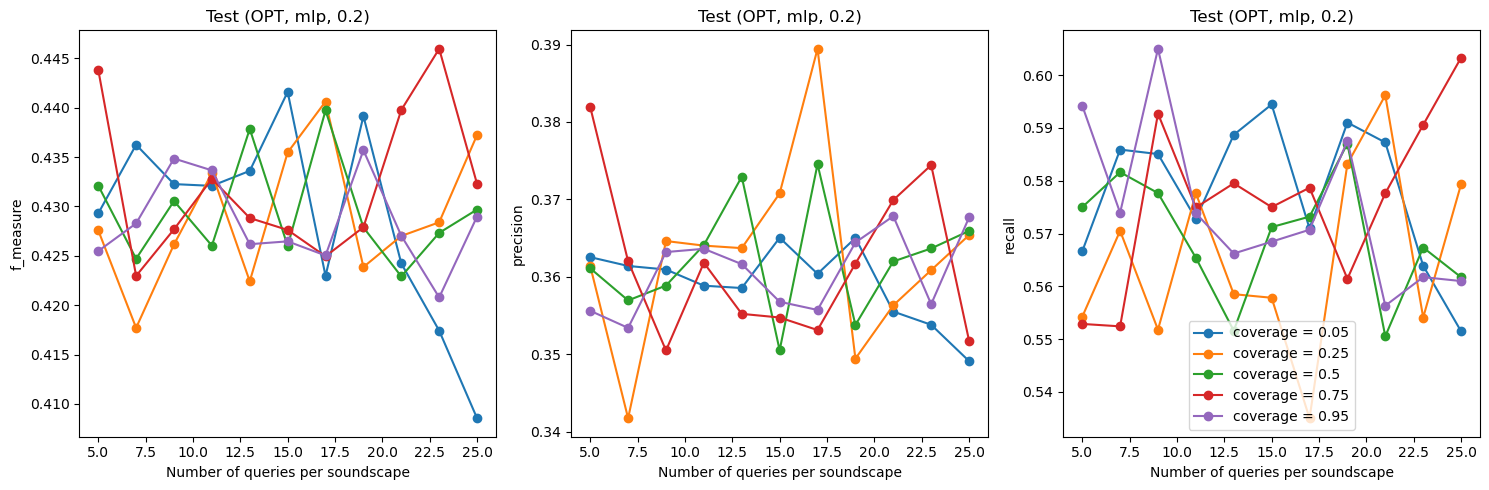

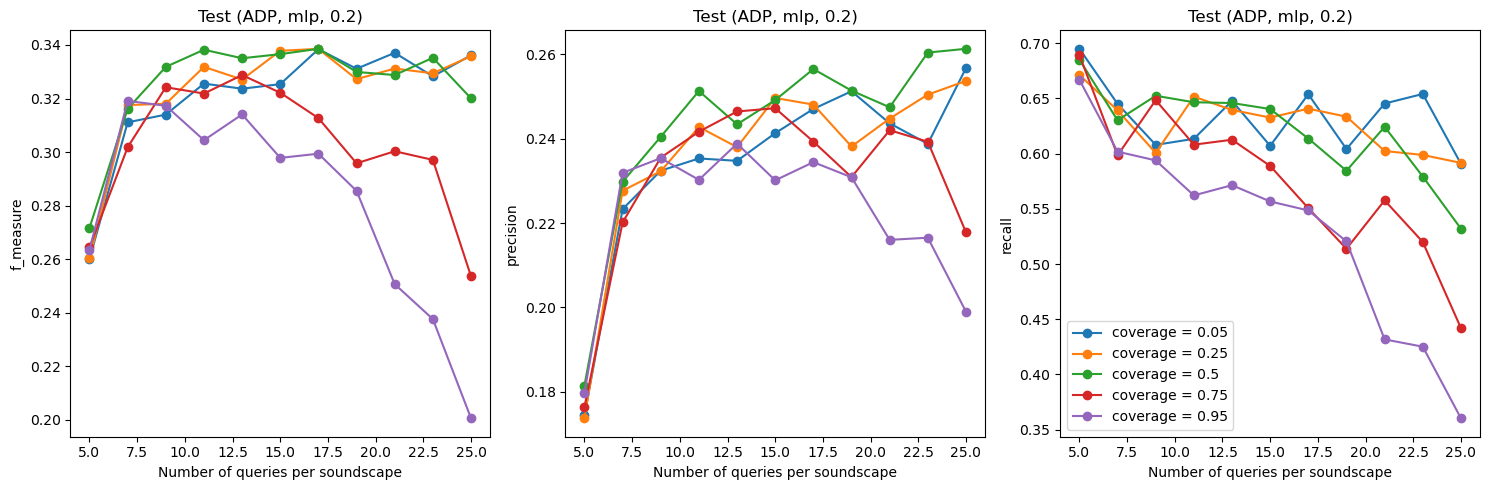

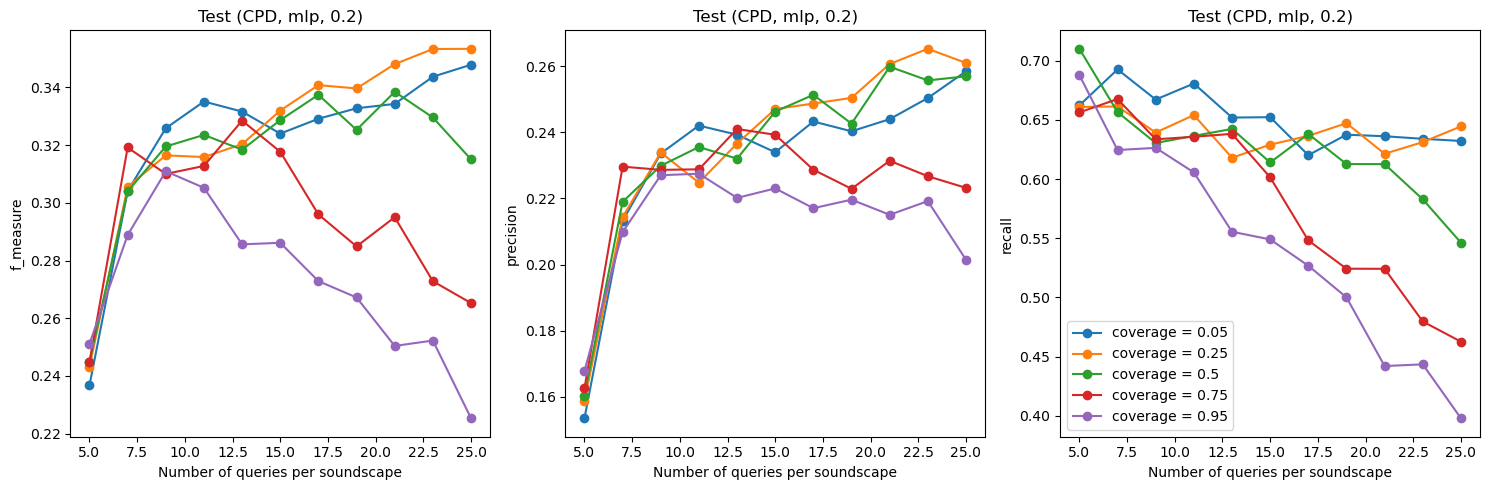

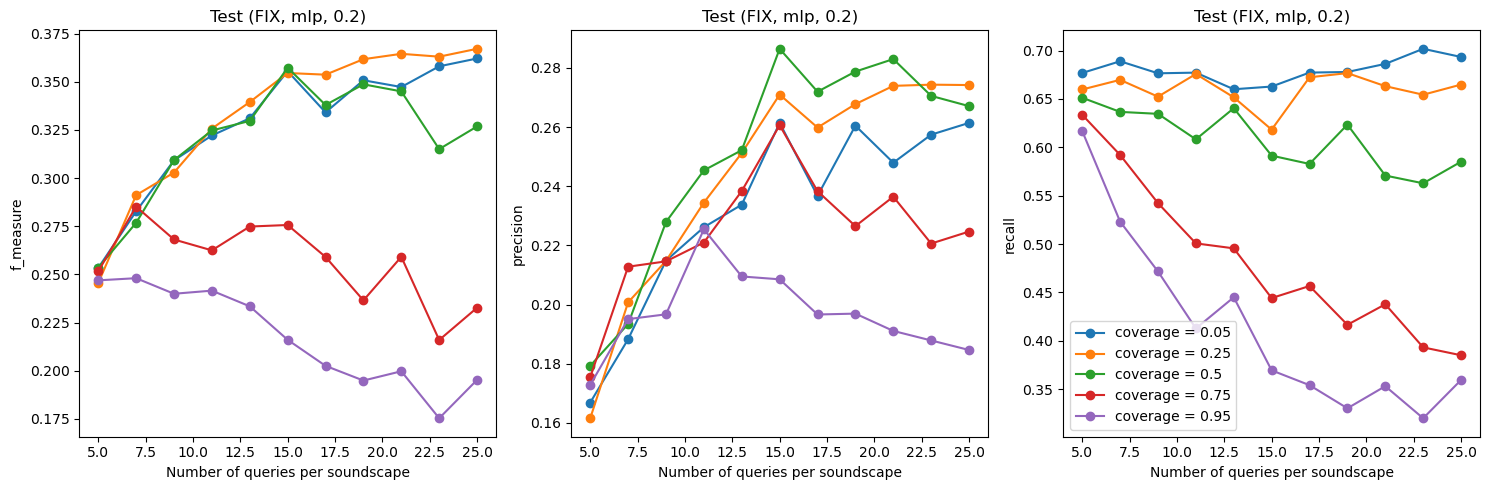

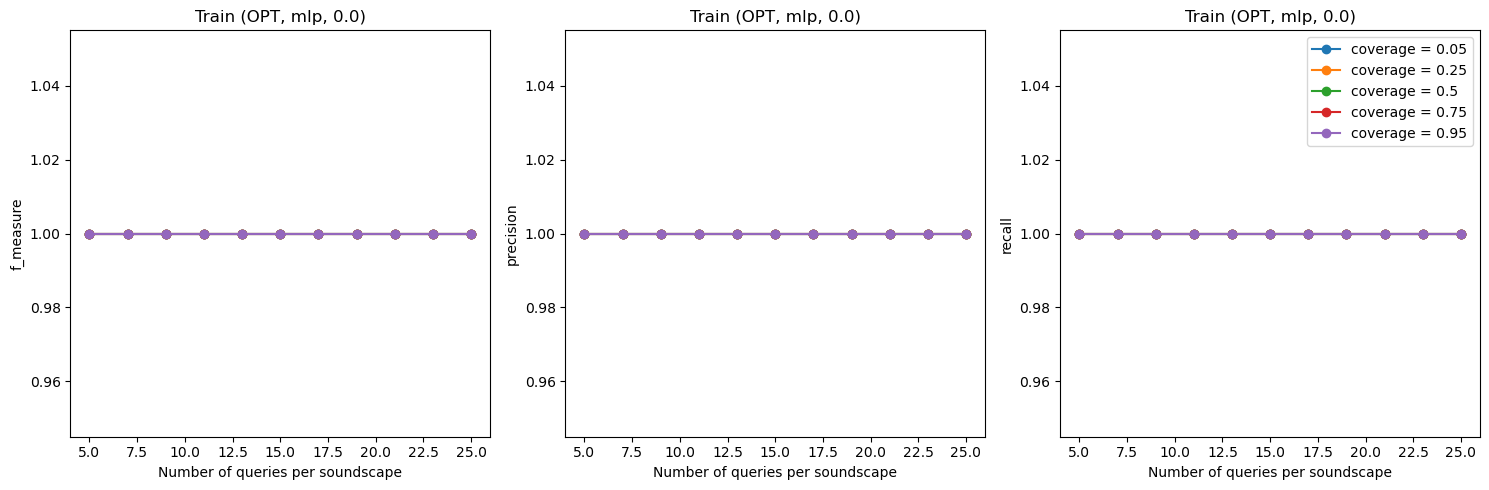

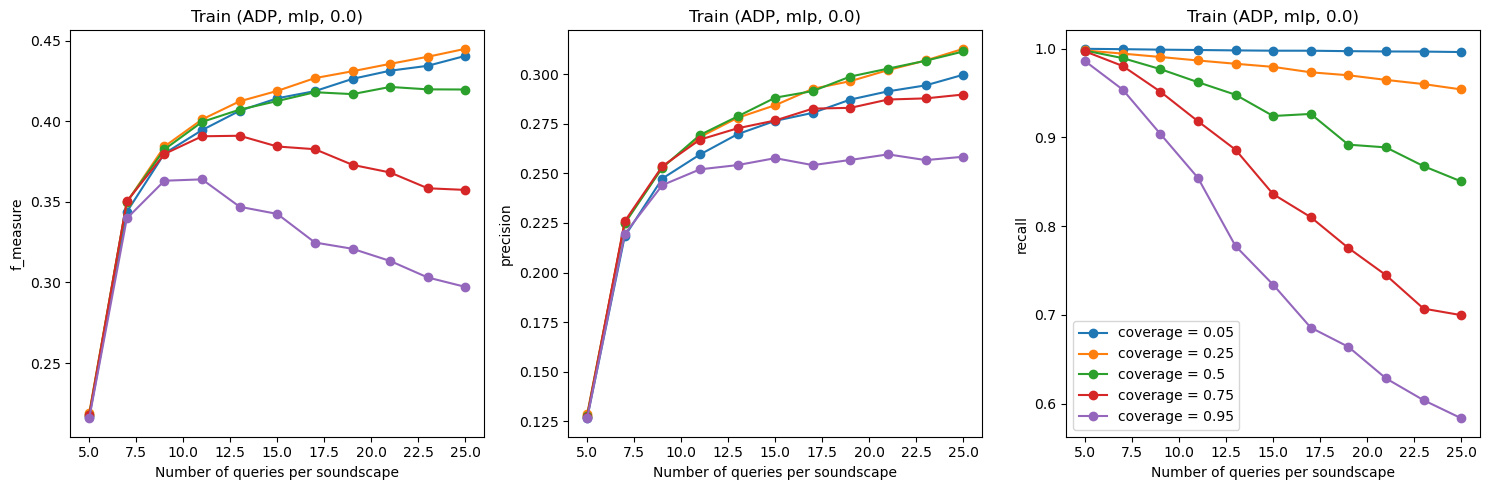

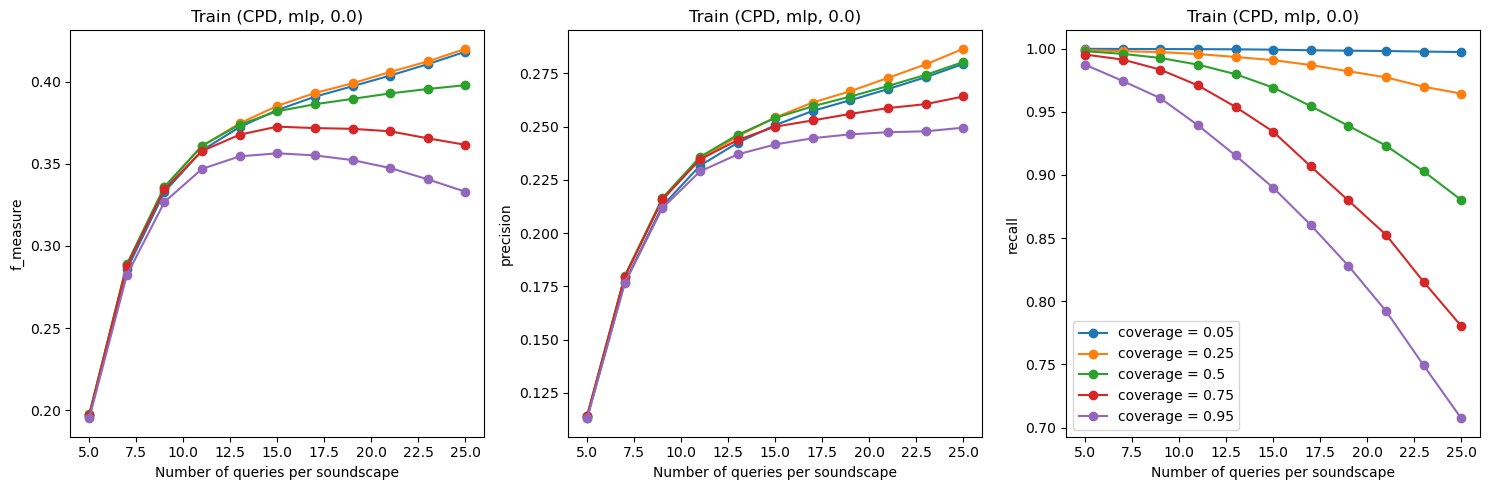

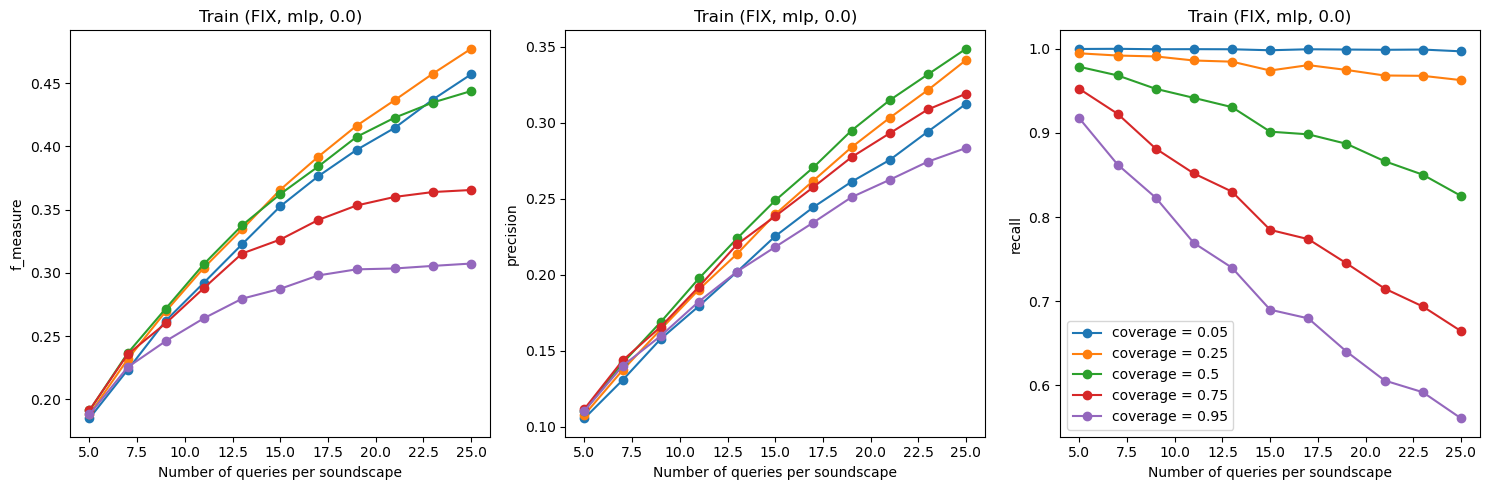

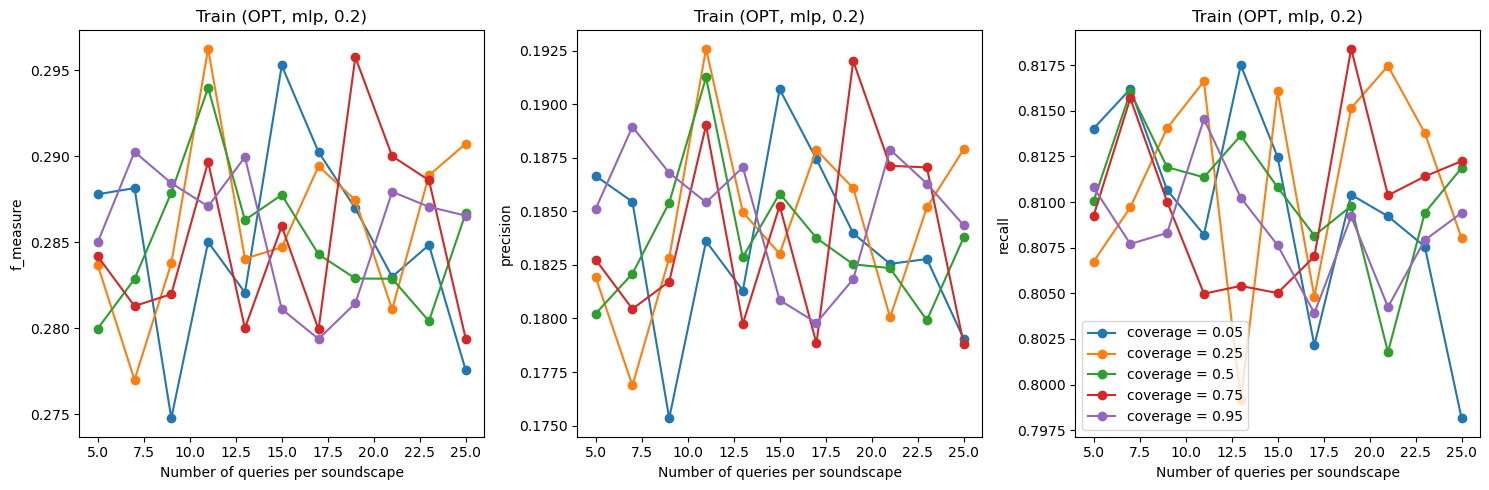

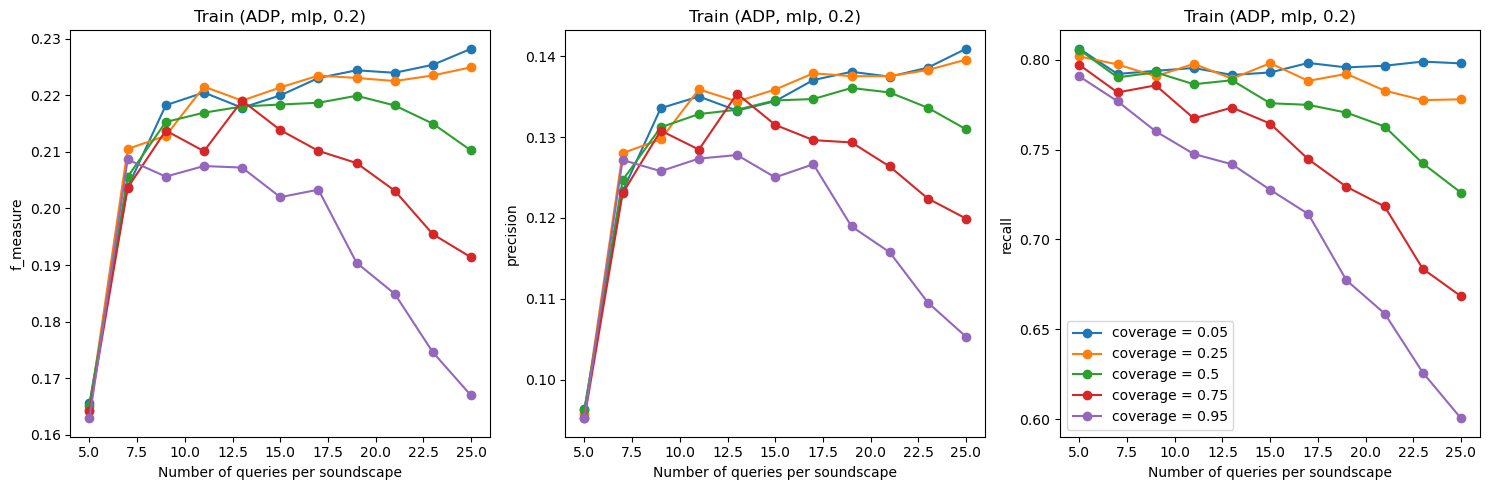

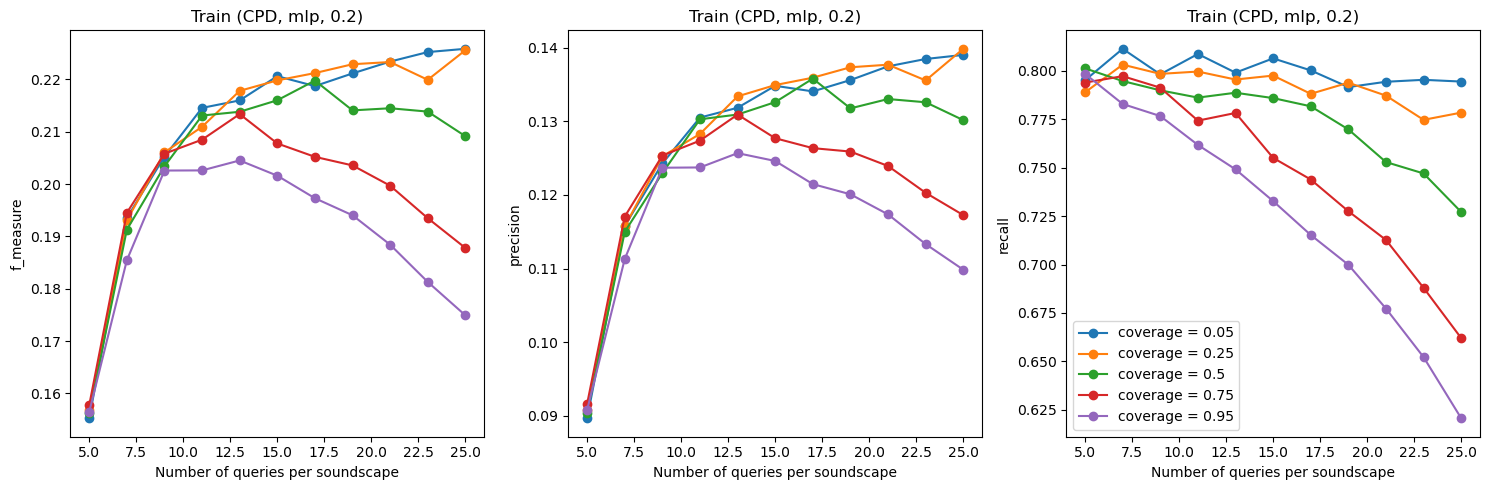

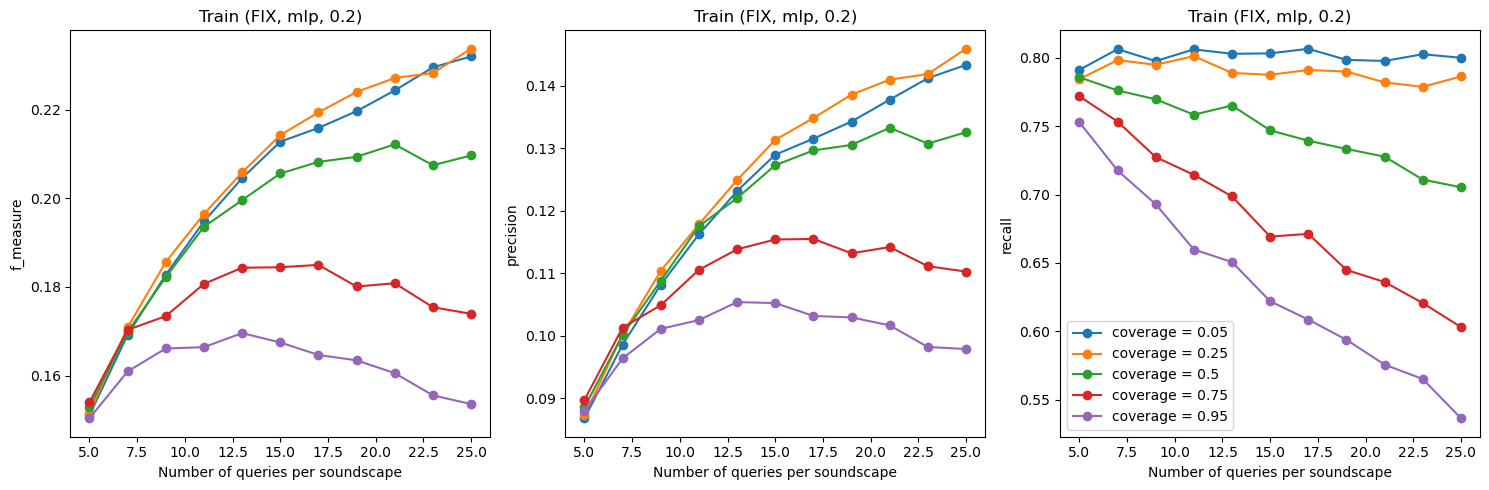

In [40]:
os.chdir('/home/john/gits/active-learning-for-bioacoustics/')


for model_name in ['prototypical', 'mlp']:
    for split in ['Test', 'Train']:
        if 'Train' in split:
            event_based_df, segment_based_df = conf.load_train_results(model_name=model_name)
        else:
            event_based_df, segment_based_df = conf.load_test_results(model_name=model_name)

        for noise in [0.0, 0.2]:
            for strategy_name in ['OPT', 'ADP', 'CPD', 'FIX']:
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                for idx, metric_name in enumerate(['f_measure', 'precision', 'recall']):
                    for coverage_threshold in [0.05, 0.25, 0.50, 0.75, 0.95]:
                        #coverage_threshold   = 0.5
                        prominence_threshold = 0.0

                        df = segment_based_df[segment_based_df['model_name'] == model_name]
                        df = df[df['fn_noise'] == noise]
                        df = df[df['fp_noise'] == noise]
                        df = df[df['prominence_threshold'] == prominence_threshold]
                        df = df[df['coverage_threshold'] == coverage_threshold]

                    
                        _df = df[df['strategy_name'] == strategy_name]
                        average_df = _df.groupby(['n_queries'])[metric_name].mean().reset_index()

                        # plot n_queries vs. f1-score
                        title = '{} ({}, {}, {})'.format(split, strategy_name, model_name, noise) #, coverage_threshold)
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel('Number of queries per soundscape')
                        ax[idx].set_ylabel(metric_name)

                        ax[idx].plot(average_df['n_queries'], average_df[metric_name], '-o', label='coverage = {}'.format(coverage_threshold))

                plt.tight_layout()
                plt.legend()
                plt.savefig('figures_same/{}_{}_{}_{}_{}_{}.png'.format(split, strategy_name, model_name, noise, metric_name, time.strftime("%Y-%m-%d_%H-%M-%S")))
                    #plt.show()

#segment_based_df

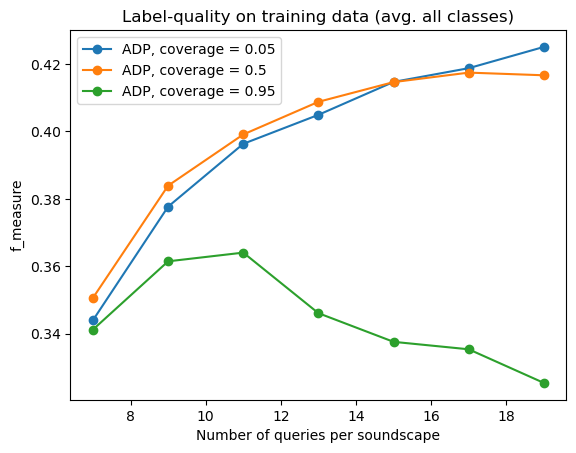

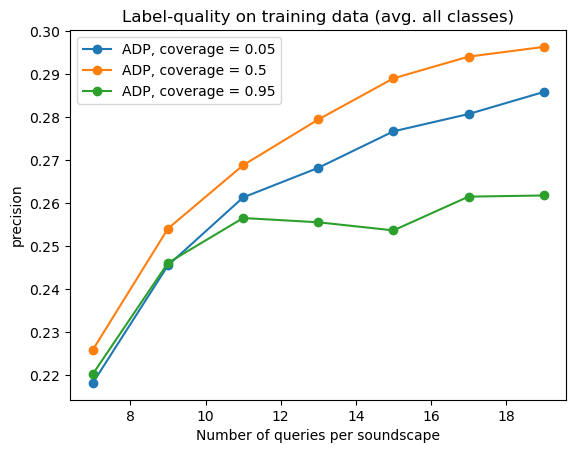

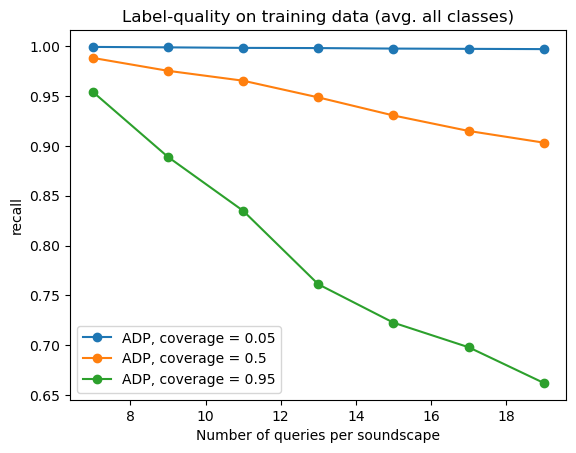

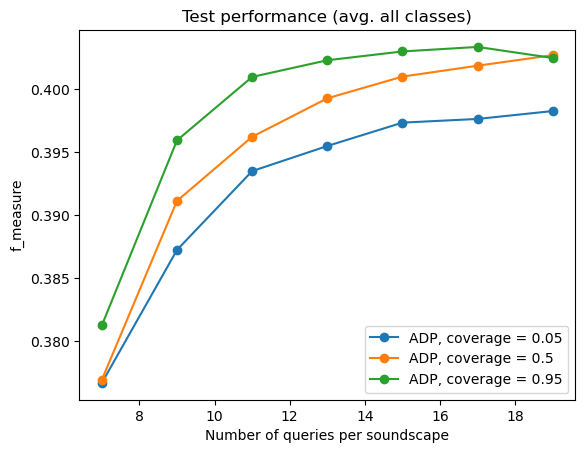

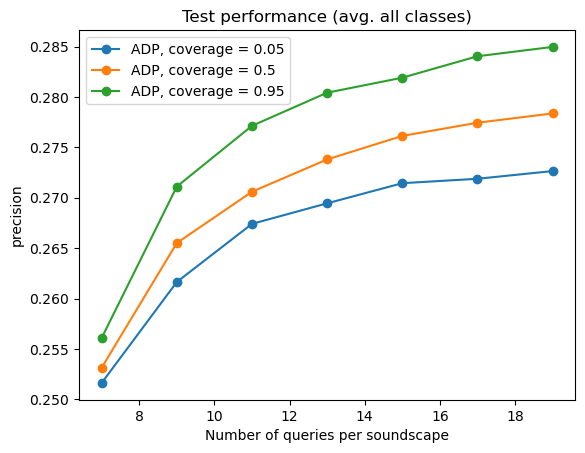

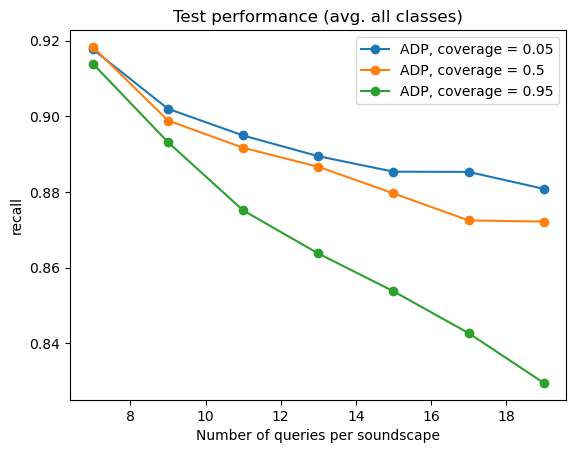

In [94]:
os.chdir('/home/john/gits/active-learning-for-bioacoustics/')

for title in ['Label-quality on training data (avg. all classes)', 'Test performance (avg. all classes)']:
    if 'train' in title:
        event_based_df, segment_based_df = conf.load_train_results()
    else:
        event_based_df, segment_based_df = conf.load_test_results()
    
    prominence_threshold = 0.0 #, 0.1]
    #coverage_threshold   = 0.5 #[0.05, 0.50, 0.95]
    #class_name           = 'baby' #['me', 'dog', 'baby']
    model_name           = 'prototypical' #, 'mlp']
    n_runs               = 2
    noise                = 0.0

    #segment_based_df = segment_based_df[segment_based_df['class_name'] == class_name]
    segment_based_df = segment_based_df[segment_based_df['model_name'] == model_name]
    segment_based_df = segment_based_df[segment_based_df['fn_noise'] == noise]
    segment_based_df = segment_based_df[segment_based_df['fp_noise'] == noise]
    segment_based_df = segment_based_df[segment_based_df['prominence_threshold'] == prominence_threshold]

    for metric_name in ['f_measure', 'precision', 'recall']:
        plt.figure()
        for strategy_name in ['ADP']:
            for coverage_threshold in [0.05, 0.5, 0.95]:
                df = segment_based_df[segment_based_df['coverage_threshold'] == coverage_threshold]
                df = df[df['strategy_name'] == strategy_name]
                #print("len(df)", len(df))
                grouped_df = df.groupby(['n_queries', 'class_name'])[metric_name].mean().reset_index()
                average_df = grouped_df.groupby(['n_queries'])[metric_name].mean()
                #std_df = grouped_df.groupby(['n_queries'])['f_measure'].std()
                #print(average_df)

                # plot n_queries vs. f1-score
                plt.title(title)
                plt.xlabel('Number of queries per soundscape')
                plt.ylabel(metric_name)
                # plot the average f_measure for each n_queries over class_name


                plt.plot(average_df.index, average_df.values, '-o', label='{}, coverage = {}'.format(strategy_name, coverage_threshold))
                #plt.fill_between(average_df.index, average_df.values - std_df.values, average_df.values + std_df.values, alpha=0.2)

        #plt.ylim(0, 1.1)
        plt.legend()
        plt.show()

#segment_based_df

In [25]:
segment_based_df.columns

Index(['prominence_threshold', 'coverage_threshold', 'n_soundscapes',
       'n_queries', 'n_runs', 'emb_win_length', 'fp_noise', 'fn_noise',
       'strategy_name', 'normal_prototypes', 'normalize_embeddings',
       'noise_factor', 'min_iou', 'class_name', 'snr', 'results_dir',
       'base_dir', 'evaluation_budgets', 'model_name', 't_collar',
       'time_resolution', 'f_measure', 'precision', 'recall', 'run', 'budget'],
      dtype='object')

In [47]:
sim_dir = '../results/test-2024-01-31/me/n_queries_30_noise_0.0_prominence_threshold_0.0_coverage_threshold_0.05/FIX'
conf = config.Config(sim_dir)

# pretty print conf
conf.time_resolution = 0.05

conf.pretty_print()
print(conf.sim_dir)

-----------------------------------------
Config:
-----------------------------------------
	prominence_threshold: 0.0
	  coverage_threshold: 0.05
	       n_soundscapes: 300
	           n_queries: 30
	              n_runs: 1
	      emb_win_length: 1.0
	            fp_noise: 0.0
	            fn_noise: 0.0
	       strategy_name: FIX
	   normal_prototypes: True
	normalize_embeddings: True
	        noise_factor: 0.0
	             min_iou: 1e-06
	          class_name: me
	                 snr: 0.0
	         results_dir: ./results/test-2024-01-31
	            base_dir: /mnt/storage_1/john/data/bioacoustic_sed/
	  evaluation_budgets: [1.0]
	          model_name: prototypical
	            t_collar: 2.0
	     time_resolution: 0.05
-----------------------------------------

./results/test-2024-01-31/me/n_queries_30_noise_0.0_prominence_threshold_0.0_coverage_threshold_0.05/FIX


In [48]:
os.chdir('..')
see.evaluate_test_and_train(conf)
os.chdir('notebooks')
#print(os.getcwd())

Evaluating method FIX run 0 budget budget_1.0


model_name: prototypical, n_queries: 7, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 9, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 11, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 13, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 15, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 17, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 19, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 7, noise: 0.0, class_name: me
model_name: prototypical, n_queries: 9, noise: 0.0, class_name: me
model_name: prototypical, n_queries: 11, noise: 0.0, class_name: me
model_name: prototypical, n_queries: 13, noise: 0.0, class_name: me
model_name: prototypical, n_queries: 15, noise: 0.0, class_name: me
model_name: prototypical, n_queries: 17, noise: 0.0, class_name: me
model_name: prototypical, n_queries: 19, noise: 0.0, class_name: me
model_name: prototypical, n_queries: 7

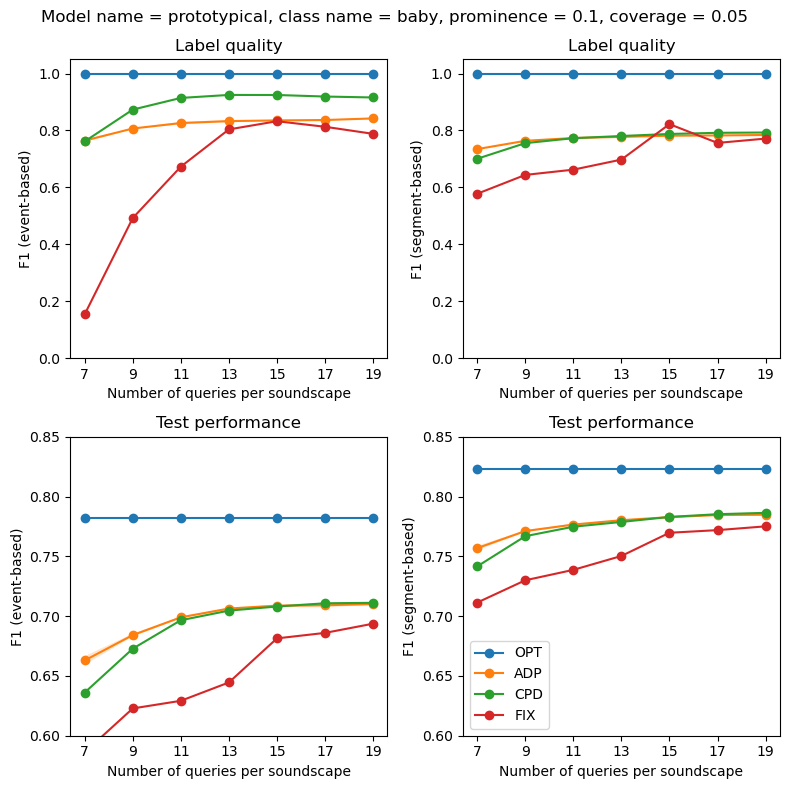

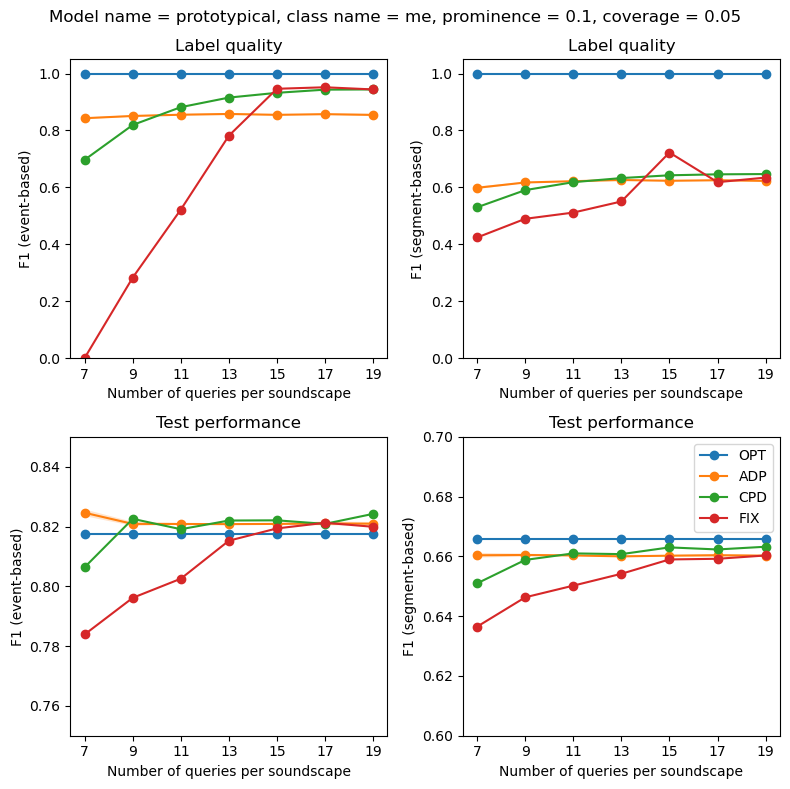

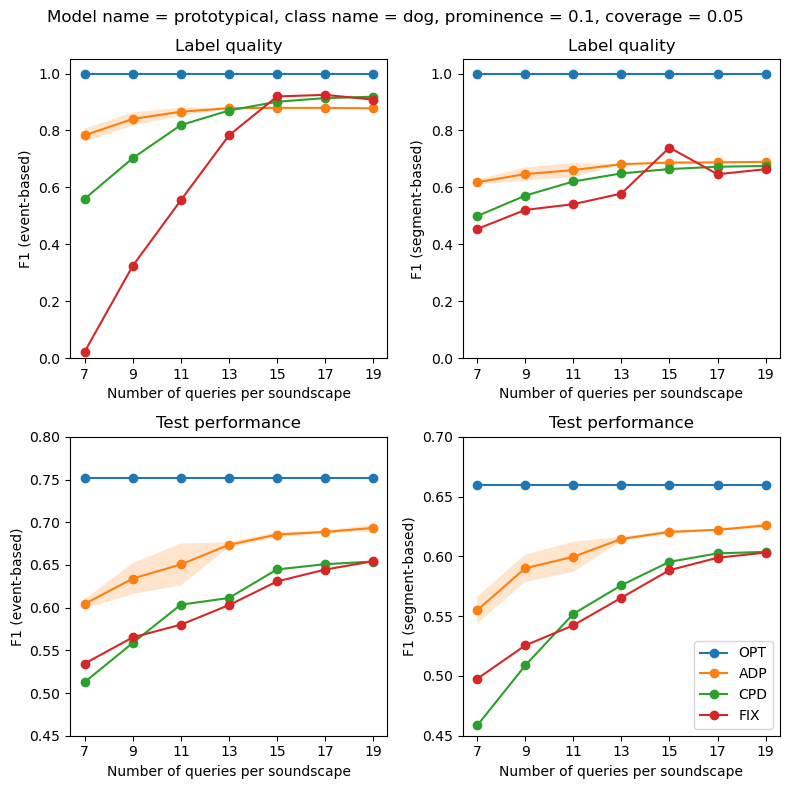

In [16]:
# results are saved as
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_train_results.npy'.format(model_name, method_name)), f1_event_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_train_results.npy'.format(model_name, method_name)), f1_segment_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_test_results.npy'.format(model_name, method_name)), f1_event_based_test_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_test_results.npy'.format(model_name, method_name)), f1_segment_based_test_results)
#
# produce figure loads the results for each model_name and method_name and plots f1_event_based_train results in one plot, f1_segment_based_train results in another plot, f1_event_based_test results in another plot, and f1_segment_based_test results in another plot.
# method_name and model_name are part of the legend in the plot



# TODO: this does not seem to do what I want.
def produce_figure_f1_vs_n_queries(result_dir, noise, class_name, n_queriess, prominence_threshold, coverage_threshold, save_dir=None):
    method_names = ['OPT', 'ADP', 'CPD', 'FIX']
    for model_name in ['prototypical']:
            results_mean = {}
            results_std = {}

            for method_name in method_names:
                results_mean[method_name] = []
                results_std[method_name] = []

            for n_queries in n_queriess:

                #prominence_threshold = 0.1
                #coverage_threshold   = 0.95

                sim_dir = os.path.join(result_dir, 'n_queries_{}_noise_{}_prominence_threshold_{}_coverage_threshold_{}/'.format(n_queries, noise, prominence_threshold, coverage_threshold))

                print("model_name: {}, n_queries: {}, noise: {}, class_name: {}".format(model_name, n_queries, noise, class_name))
                
                for method_name in method_names:
                    
                    f1_event_based_train_results = np.load(os.path.join(sim_dir, method_name, '{}_f1_event_based_train_results.npy'.format(model_name)))
                    f1_segment_based_train_results = np.load(os.path.join(sim_dir, method_name, '{}_f1_segment_based_train_results.npy'.format(model_name)))
                    f1_event_based_test_results = np.load(os.path.join(sim_dir, method_name, '{}_f1_event_based_test_results.npy'.format(model_name)))
                    f1_segment_based_test_results = np.load(os.path.join(sim_dir, method_name, '{}_f1_segment_based_test_results.npy'.format(model_name)))

                    results_mean[method_name].append([f1_event_based_train_results.mean(), f1_segment_based_train_results.mean(), f1_event_based_test_results.mean(), f1_segment_based_test_results.mean()])
                    results_std[method_name].append([f1_event_based_train_results.std(), f1_segment_based_train_results.std(), f1_event_based_test_results.std(), f1_segment_based_test_results.std()])


            # results arrays have shape (n_methods, n_runs, n_budgets)
            # we want to plot the mean and std over runs, for each method, with budget on the x-axis
            # so we want to plot the mean and std over axis 1

            suptitle = "Model name = {}, class name = {}, prominence = {}, coverage = {}".format(model_name, class_name, prominence_threshold, coverage_threshold)
            fig, ax = plt.subplots(2, 2, figsize=(8, 8))
            for idx_method, method_name in enumerate(method_names):
                method_mean_result = np.array(results_mean[method_name])
                method_std_result = np.array(results_std[method_name])
                for idx_result in range(4):
                    y = np.array([r[idx_result] for r in method_mean_result])
                    yerr = np.array([r[idx_result] for r in method_std_result])

                    ax[idx_result // 2, idx_result % 2].plot(y, label=method_names[idx_method], marker='o')
                    ax[idx_result // 2, idx_result % 2].fill_between(np.arange(len(y)), y - yerr, y + yerr, alpha=0.2)
                    ax[idx_result // 2, idx_result % 2].set_xlabel('Number of queries per soundscape')
                    if idx_result % 2 == 0:
                        ax[idx_result // 2, idx_result % 2].set_ylabel('F1 (event-based)')
                    else:
                        ax[idx_result // 2, idx_result % 2].set_ylabel('F1 (segment-based)')

            for xs in ax:
                for a in xs:
                    a.set_xticks(np.arange(len(n_queriess)))
                    a.set_xticklabels(n_queriess)
            ax[0,0].set_title('Label quality')
            ax[0,1].set_title('Label quality') # ({})'.format(class_name))
            ax[1,0].set_title('Test performance') # ({})'.format(model_name))
            ax[1,1].set_title('Test performance') # ({})'.format(model_name))

            if class_name == 'baby':
                mi_e = 0.6
                ma_e = 0.85
                mi_s = 0.6
                ma_s = 0.85
            elif class_name == 'me':
                mi_e = 0.75
                ma_e = 0.85
                mi_s = 0.6
                ma_s = 0.7
            elif class_name == 'dog':
                mi_e = 0.45
                ma_e = 0.8
                mi_s = 0.45
                ma_s = 0.7
            else:
                raise ValueError("Unknown class name {}".format(class_name))
                
            ax[1,0].set_ylim(mi_e, ma_e)
            ax[1,1].set_ylim(mi_s, ma_s)

            ax[0,0].set_ylim(0.0, 1.05)
            ax[0,1].set_ylim(0.0, 1.05)

            # for idx_split in range(2):
            #     xs = ax[idx_split]
            #     mis = []
            #     mas = []
            #     for a in xs:
            #         mi = a.get_ylim()[0]
            #         ma = a.get_ylim()[1]
            #         mis.append(mi)
            #         mas.append(ma)
            #     for a in xs:
            #         a.set_ylim(min(mis)-0.1, max(mas)+0.1)
                
            
            plt.suptitle(suptitle)
            plt.tight_layout()
            plt.legend()

            if save_dir is not None:
                fig_path = os.path.join(save_dir, "model_{}_class_{}_noise_{}_prominence_{}_coverage_{}.png".format(model_name, class_name, noise, prominence_threshold, coverage_threshold))
                plt.savefig(os.path.join(fig_path))
            else:
                plt.show()

n_queriess = [7, 9, 11, 13, 15, 17, 19] #[5, 7, 10, 15, 20, 25, 30] #, 35, 40]
budget = 1.0
prominence_threshold = 0.1
coverage_threshold = 0.05

for class_name in ['baby', 'me', 'dog']:
    produce_figure_f1_vs_n_queries(result_dir='../results/2024-01-29/{}/'.format(class_name), noise=0.0, class_name=class_name, n_queriess=n_queriess, prominence_threshold=prominence_threshold, coverage_threshold=coverage_threshold, save_dir="figures_n_queries")

#produce_figure(result_dir='../results/5_runs/me/', n_queries=7, noise=0.25, class_name='me', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=20, noise=0.0, class_name='me', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=20, noise=0.25, class_name='me', save_dir=None)

results shape:  (4, 5, 8)
results shape:  (4, 5, 8)


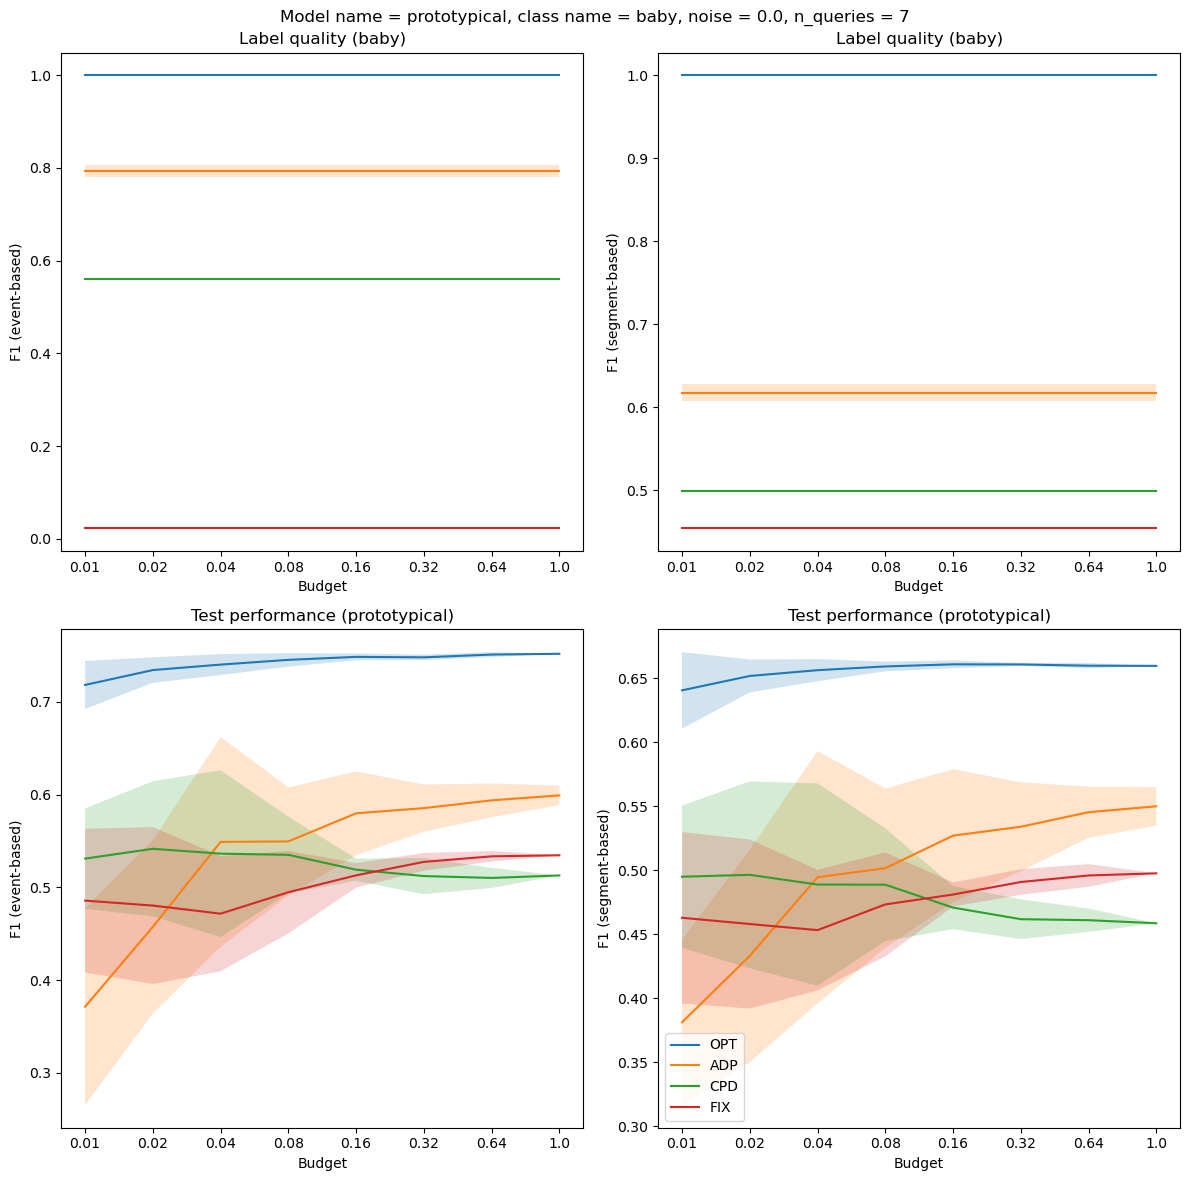

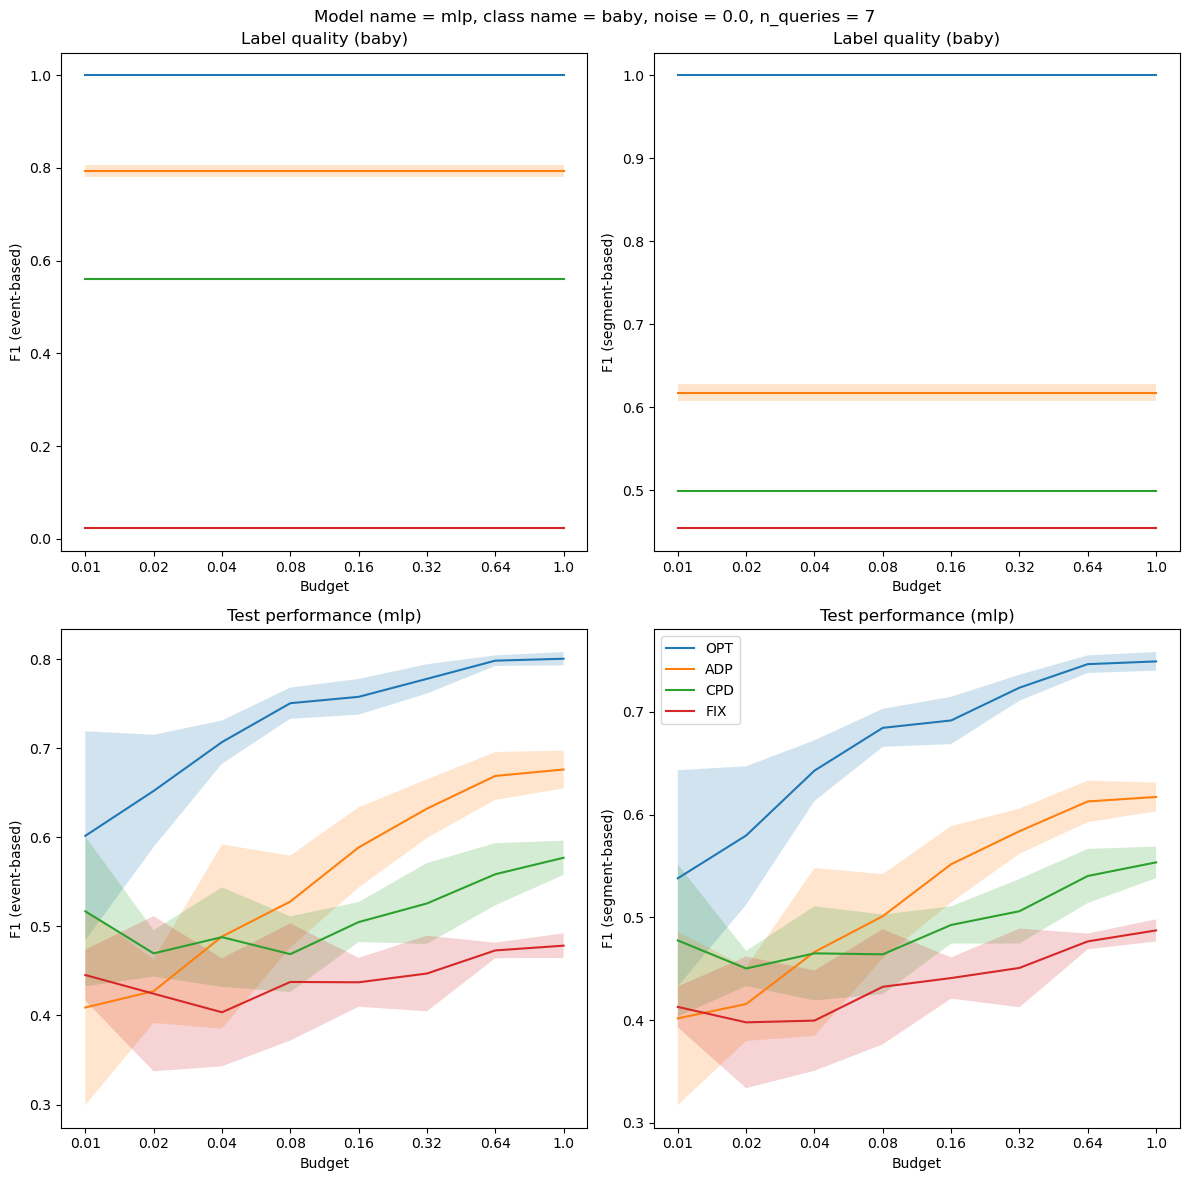

In [3]:
# results are saved as
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_train_results.npy'.format(model_name, method_name)), f1_event_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_train_results.npy'.format(model_name, method_name)), f1_segment_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_test_results.npy'.format(model_name, method_name)), f1_event_based_test_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_test_results.npy'.format(model_name, method_name)), f1_segment_based_test_results)
#
# produce figure loads the results for each model_name and method_name and plots f1_event_based_train results in one plot, f1_segment_based_train results in another plot, f1_event_based_test results in another plot, and f1_segment_based_test results in another plot.
# method_name and model_name are part of the legend in the plot
method_names = ['OPT', 'ADP', 'CPD', 'FIX']
def produce_figure(result_dir, n_queries, noise, class_name, save_dir):
    sim_dir = os.path.join(result_dir, 'n_queries_{}_noise_{}/'.format(n_queries, noise))
    for model_name in ['prototypical', 'mlp']:
        f1_event_based_train_results = np.load(os.path.join(sim_dir, '{}_f1_event_based_train_results.npy'.format(model_name)))
        f1_segment_based_train_results = np.load(os.path.join(sim_dir, '{}_f1_segment_based_train_results.npy'.format(model_name)))
        f1_event_based_test_results = np.load(os.path.join(sim_dir, '{}_f1_event_based_test_results.npy'.format(model_name)))
        f1_segment_based_test_results = np.load(os.path.join(sim_dir, '{}_f1_segment_based_test_results.npy'.format(model_name)))
        print("results shape: ", f1_event_based_train_results.shape)

        results = [f1_event_based_train_results, f1_segment_based_train_results, f1_event_based_test_results, f1_segment_based_test_results]

        # results arrays have shape (n_methods, n_runs, n_budgets)
        # we want to plot the mean and std over runs, for each method, with budget on the x-axis
        # so we want to plot the mean and std over axis 1

        suptitle = "Model name = {}, class name = {}, noise = {}, n_queries = {}".format(model_name, class_name, noise, n_queries)
        fig, ax = plt.subplots(2, 2, figsize=(12, 12))
        for idx_result, result in enumerate(results):
            for idx_method in range(4):
                y = np.mean(result[idx_method], axis=0)
                yerr = np.std(result[idx_method], axis=0)
                ax[idx_result // 2, idx_result % 2].plot(y, label=method_names[idx_method])
                ax[idx_result // 2, idx_result % 2].fill_between(np.arange(len(y)), y - yerr, y + yerr, alpha=0.2)
                ax[idx_result // 2, idx_result % 2].set_xlabel('Budget')
                if idx_result % 2 == 0:
                    ax[idx_result // 2, idx_result % 2].set_ylabel('F1 (event-based)')
                else:
                    ax[idx_result // 2, idx_result % 2].set_ylabel('F1 (segment-based)')

        budgets = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0]
        for xs in ax:
            for a in xs:
                a.set_xticks(np.arange(len(budgets)))
                a.set_xticklabels(budgets)
        ax[0,0].set_title('Label quality ({})'.format(class_name))
        ax[0,1].set_title('Label quality ({})'.format(class_name))
        ax[1,0].set_title('Test performance ({})'.format(model_name))
        ax[1,1].set_title('Test performance ({})'.format(model_name))
        
        plt.suptitle(suptitle)
        plt.tight_layout()
        plt.legend()
        
class_name = 'dog'
produce_figure(result_dir='../results/5_runs/{}/'.format(class_name), n_queries=7, noise=0.0, class_name='baby', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=7, noise=0.25, class_name='me', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=20, noise=0.0, class_name='me', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=20, noise=0.25, class_name='me', save_dir=None)

NameError: name 'os' is not defined

# Derive the training scores for the training data

In [14]:
# test evaluation of the annotations to better understand the metric

# extract nonoverlapping timings with label and create train_scores.tsv
# 
# onset   offset   class1
# 1.0     2.0      0 
# 2.0     3.0      1
# (et cetera)
#
# save to train scores

# for OPT save to ground_truth.tsv
# filename	onset	offset	event_label
# test1.wav	3.98	4.86	class2
# test1.wav	9.05	10.0	class3
# test2.wav	0.0	    4.07	class1
# test2.wav	0.0	    8.54	class2
# test2.wav	5.43	7.21	class1

# load the annotations
#model_name = 'logistic_regression'

# TODO: this should be part of the evaluate.py script
def predict_train_data(sim_dir, base_dir, class_name, method_name, idx_run, emb_win_length=1.0):
    # print the class name, method name, and run index
    # to stdout so we can see the progress, and then flush
    sys.stdout.write("Class: {}, Method: {}, Run: {}\n".format(class_name, method_name, idx_run))
    sys.stdout.flush()
    #print("Class: {}, Method: {}, Run: {}".format(class_name, method_name, idx_run))
            
    run_dir                     = os.path.join(sim_dir, method_name, str(idx_run))
    train_soundscape_file_paths = glob.glob(os.path.join(base_dir, '*.wav'))
    #print(base_dir)
    train_annotation_file_paths = glob.glob(os.path.join(run_dir, 'train_annotations', '*.tsv'))
    train_scores_dir            = os.path.join(run_dir, 'train_scores')

    if not os.path.exists(train_scores_dir):
        os.makedirs(train_scores_dir)
    if not os.path.exists(os.path.join(train_scores_dir, 'event_based')):
        os.makedirs(os.path.join(train_scores_dir, 'event_based'))
    if not os.path.exists(os.path.join(train_scores_dir, 'segment_based')):
        os.makedirs(os.path.join(train_scores_dir, 'segment_based'))


    def get_soundscape_basename(fp):
        return os.path.splitext(os.path.basename(fp))[0]

    def get_soundscape_id(fp):
        return os.path.basename(fp).split('_')[-1].split('.')[0]

    #print(train_soundscape_file_paths)

    for train_soundscape_file_path in train_soundscape_file_paths:
        train_sounscape_basename = get_soundscape_basename(train_soundscape_file_path)
        train_annotation_file    = [fp for fp in train_annotation_file_paths if get_soundscape_id(fp) == get_soundscape_id(train_sounscape_basename)][0]
        
        # TODO: pre-load embeddings and timings, takes ~0.01s
        timings, embeddings = datasets.load_timings_and_embeddings(base_dir, train_sounscape_basename)
        pos_ann = evaluate.get_positive_annotations(train_annotation_file)
        #print(pos_ann)
        
        # TODO: pre-load embedding labels, takes ~0.01s
        _, _, embs_label = evaluate.get_embeddings_3(pos_ann, base_dir, train_sounscape_basename, emb_win_length)
        taus = np.mean(timings, axis=1)
        window_timings = [(tau - emb_win_length / 2, tau + emb_win_length / 2) for tau in taus]

        idx_nonoverlapping = np.arange(len(window_timings)) % 4 == 0
        window_timings_nonoverlapping = np.array(window_timings)[idx_nonoverlapping]
        embs_label_nonoverlapping     = embs_label[idx_nonoverlapping]
        
        # Event-based for collar eval
        with open(os.path.join(train_scores_dir, 'event_based', train_sounscape_basename + '.txt'), 'w') as f:
            for (s, e) in pos_ann:
                f.write('{}\t{}\t{}\n'.format(s, e, class_name))

        # Segment-based for PSDS eval
        with open(os.path.join(train_scores_dir, 'segment_based', train_sounscape_basename + '.tsv'), 'w') as f:
            f.write('onset\toffset\t{}\n'.format(class_name))
            for (s, e), l in zip(window_timings_nonoverlapping, embs_label_nonoverlapping):
                f.write('{}\t{}\t{}\n'.format(s, e, l))

n_runs = 2
emb_win_length = 1.0
emb_hop_length = 0.25

for class_name in ['dog', 'baby', 'me']:
    sim_dir = '../results/{}_runs/{}/n_queries_7_fp_noise_0.0_fn_noise_0.0/'.format(n_runs, class_name)
    train_base_dir = '/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/{}_{}_{}s/train_soundscapes_snr_0.0'.format(class_name, emb_win_length, emb_hop_length)
    for method_name in ['OPT', 'ADP', 'CPD', 'FIX']:
        for idx_run in range(n_runs):
            predict_train_data(sim_dir, train_base_dir, class_name, method_name, idx_run, emb_win_length=emb_win_length)

Class: me, Method: OPT, Run: 0


/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: OPT, Run: 1
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: ADP, Run: 0
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: ADP, Run: 1
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: CPD, Run: 0
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: CPD, Run: 1
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: FIX, Run: 0
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: FIX, Run: 1
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes

# Evaluate label-quality on training data

In [19]:
# Assumes that the evaluate_all.sh script has been run
# which produces the test_scores directory and the predictions
# for each method and soundscape

# prepare the ground_truth.tsv and audio_durations.tsv files
emb_win_length = 1.0
emb_hop_length = emb_win_length / 4

emb_hop_length_str = '{:.2f}'.format(emb_hop_length)
emb_win_length_str = '{:.1f}'.format(emb_win_length)

method_names = ['OPT', 'ADP', 'FIX', 'CPD']
class_names  = ['dog', 'baby', 'me']
idx_runs     = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

n_classes = len(class_names)
n_runs    = len(idx_runs)
n_methods = len(method_names)

psds_scores = np.zeros((n_methods, n_classes, n_runs))

# predictions
for idx_class_name, class_name in enumerate(class_names):
    print("########################")
    print("Class name: ", class_name)
    print("########################")
    test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/{}_{}_{}s/test_soundscapes_snr_0.0'.format(class_name, emb_win_length, emb_hop_length)
    train_base_dir = test_base_dir.replace('test', 'train')
    print(train_base_dir)

    # test data
    gt_file             = os.path.join(train_base_dir, 'ground_truth.tsv')
    audio_duration_file = os.path.join(train_base_dir, 'audio_durations.tsv')

    for idx_method_name, method_name in enumerate(method_names):
        for idx_run, run in enumerate(idx_runs):
            scores_dir  = '../results/10_runs/{}/n_queries_7_fp_noise_0.0_fn_noise_0.0/{}/{}/train_scores/segment_based/'.format(class_name, method_name, run)
            # PSDS parameters
            thr = 0.1
            dtc_threshold = thr
            gtc_threshold = thr
            cttc_threshold = None
            alpha_st = 1.0
            alpha_ct = 0.0
            max_efpr = 100.0

            psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
                scores          = scores_dir,
                ground_truth    = gt_file,
                audio_durations = audio_duration_file,
                dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
                cttc_threshold  = cttc_threshold,
                alpha_ct        = alpha_ct,
                alpha_st        = alpha_st,
                unit_of_time    = 'hour',
                max_efpr        = max_efpr,
            )
            psds_scores[idx_method_name, idx_class_name, idx_run] = psds
            
        _psds_scores = psds_scores[idx_method_name, idx_class_name]
        print('Class = {}, Method = {}, PSDS = {} +/- {}'.format(class_name, method_name, np.mean(_psds_scores), np.std(_psds_scores)))

########################
Class name:  dog
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/dog_1.0_0.25s/train_soundscapes_snr_0.0
Class = dog, Method = OPT, PSDS = 0.8798933333333336 +/- 1.1102230246251565e-16
Class = dog, Method = ADP, PSDS = 0.09739733333333335 +/- 0.038610489242634
Class = dog, Method = FIX, PSDS = 0.0 +/- 0.0
Class = dog, Method = CPD, PSDS = 0.0 +/- 0.0
########################
Class name:  baby
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0_0.25s/train_soundscapes_snr_0.0
Class = baby, Method = OPT, PSDS = 0.9243333333333332 +/- 0.0
Class = baby, Method = ADP, PSDS = 0.6921803333333334 +/- 0.021865894673872576
Class = baby, Method = FIX, PSDS = 0.5596333333333332 +/- 0.0
Class = baby, Method = CPD, PSDS = 0.68442 +/- 1.1102230246251565e-16
########################
Class name:  me
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_s

# Evaluate the predictions on the test data

In [12]:
# Assumes that the evaluate_all.sh script has been run
# which produces the test_scores directory and the predictions
# for each method and soundscape

# prepare the ground_truth.tsv and audio_durations.tsv files
emb_win_length = 1.0
emb_hop_length = emb_win_length / 4

emb_hop_length_str = '{:.2f}'.format(emb_hop_length)
emb_win_length_str = '{:.1f}'.format(emb_win_length)

method_names = ['OPT', 'ADP', 'FIX', 'CPD']
class_names  = ['dog', 'baby', 'me']
idx_runs     = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

n_classes = len(class_names)
n_runs    = len(idx_runs)
n_methods = len(method_names)

segement_based_f1_scores = np.zeros((n_methods, n_classes, n_runs))
event_based_f1_scores    = np.zeros((n_methods, n_classes, n_runs))

budget = '0.08'

# predictions
for idx_class_name, class_name in enumerate(class_names):
    print("########################")
    print("Class name: ", class_name)
    print("########################")
    test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/{}_{}_{}s/test_soundscapes_snr_0.0'.format(class_name, emb_win_length, emb_hop_length)
    print(test_base_dir)

    # test data
    gt_file             = os.path.join(test_base_dir, 'ground_truth.tsv')
    audio_duration_file = os.path.join(test_base_dir, 'audio_durations.tsv')

    for idx_method_name, method_name in enumerate(method_names):
        for idx_run, run in enumerate(idx_runs):
            scores_dir  = '../results/10_runs/{}/n_queries_7_fp_noise_0.0_fn_noise_0.0/{}/{}/test_scores/budget_{}/segment_based/'.format(class_name, method_name, idx_run, budget)
            # PSDS parameters
            thr = 0.2
            dtc_threshold = thr
            gtc_threshold = thr
            cttc_threshold = None
            alpha_st = 1.0
            alpha_ct = 0.0
            max_efpr = 100.0

            psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
                scores          = scores_dir,
                ground_truth    = gt_file,
                audio_durations = audio_duration_file,
                dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
                cttc_threshold  = cttc_threshold,
                alpha_ct        = alpha_ct,
                alpha_st        = alpha_st,
                unit_of_time    = 'hour',
                max_efpr        = max_efpr,
            )
            print('Method = {}, PSDS = {}'.format(method_name, psds))

            # Event-based for collar eval
            event_based_f1_scores[idx_method_name, idx_class_name, idx_run] = evaluate.evaluate_event_based(gt_file, scores_dir)

            # Segment-based for PSDS eval
            segement_based_f1_scores[idx_method_name, idx_class_name, idx_run] = evaluate.evaluate_segment_based(gt_file, scores_dir)
        scores_dir  = '../results/10_runs/{}/n_queries_7_fp_noise_0.0_fn_noise_0.0/{}/{}/test_scores/budget_{}/segment_based/'.format(class_name, method_name, idx_run, budget)
        # PSDS parameters
        thr = 0.2
        dtc_threshold = thr
        gtc_threshold = thr
        cttc_threshold = None
        alpha_st = 1.0
        alpha_ct = 0.0
        max_efpr = 100.0

        psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
            scores          = scores_dir,
            ground_truth    = gt_file,
            audio_durations = audio_duration_file,
            dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
            cttc_threshold  = cttc_threshold,
            alpha_ct        = alpha_ct,
            alpha_st        = alpha_st,
            unit_of_time    = 'hour',
            max_efpr        = max_efpr,
        )
        print('Method = {}, PSDS = {}'.format(method_name, psds))

########################
Class name:  dog
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/dog_1.0_0.25s/test_soundscapes_snr_0.0
Method = OPT, PSDS = 0.14347000000000001
Method = ADP, PSDS = 0.1537033333333333
Method = FIX, PSDS = 0.14954333333333336
Method = CPD, PSDS = 0.15808000000000003
########################
Class name:  baby
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0_0.25s/test_soundscapes_snr_0.0
Method = OPT, PSDS = 0.9243466666666665
Method = ADP, PSDS = 0.9225233333333333
Method = FIX, PSDS = 0.9223866666666667
Method = CPD, PSDS = 0.9244333333333333
########################
Class name:  me
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_1.0_0.25s/test_soundscapes_snr_0.0
Method = OPT, PSDS = 0.5384933333333334
Method = ADP, PSDS = 0.51512
Method = FIX, PSDS = 0.47585333333333324
Method = CPD, PSDS = 0.4067366666666667


# Understanding the metric by introducing controlled problems

In [18]:
for scores_dir in ['./scores_gt', './scores_1']:
    gt_file    = './ground_truth.tsv'
    dur_file   = './audio_durations.tsv'

    # PSDS parameters
    dtc_threshold = 1.0
    gtc_threshold = 0.60
    cttc_threshold = None
    alpha_st = 1.0
    alpha_ct = 0.0
    max_efpr = 100.0

    psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
        scores          = scores_dir,
        ground_truth    = gt_file,
        audio_durations = dur_file,
        dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
        cttc_threshold  = cttc_threshold,
        alpha_ct        = alpha_ct,
        alpha_st        = alpha_st,
        unit_of_time    = 'hour',
        max_efpr        = max_efpr,
    )
    print('Scores = {}, PSDS = {}'.format(scores_dir, psds))

Scores = ./scores_gt, PSDS = 1.0
Scores = ./scores_1, PSDS = 1.0


# sed_eval, segment-based and event-based

In [34]:
# 1. create file_list with all the file pairs
#    a. reference file (always the same for the given class_name)
#    b. estimated file (varies with method and run)
#
# 2. copy relevant parts from the evlauation script
#    and derive the evaluation scores for each class name
#    and method name
#
# 3. produce a table for each class name / dataset where the
#    the event-based and segment-based F-score is presented.
#
#       
#       Event-based     Segment-based
# OPT   mean +/- std    mean +/- std
# ADP   
# CPD
# FIX
#
#
# Comment 1: The event-based F-score serves a similar purpose as the
# one we have looked at so far. However, the choice of collar timings
# will determine whether or not a method catastrophically fails or
# not. I sort of prefer the old score.
#
# Comment 2: The segment-based F-score serves a similar purpose to the
# intersection-over-union score that we have looked at before. There is
# some choice on how to discretize things into segments which affects
# results, but I do not think it is that problematic.